In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS
from qs_mps.utils import create_sequential_colors

model = "Z2_dual"
bc = "pbc"
path = "/Users/fradm/Desktop/projects/1_Z2"
path_figures = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"

In [5]:
L = 70
N = 4
d = 2**N
chi = 128
g = 0.8
R = 0
cx = get_cx(L, R)
cy = get_cy(N, bc, R=R)
cx = np.nan
cy = np.nan

lattice = MPS(L=L, d=d, model=model, chi=chi, h=g, bc=bc)
if R != 0:
    lattice.Z2.add_charges(cx,cy)
    lattice.Z2._define_sector()
lattice.load_sites(path, precision=3, cx=cx, cy=cy)

Metadata: {'L': 70, 'bc': 'pbc', 'chi': 128, 'cx': nan, 'cy': nan, 'h': 0.8, 'l': 4, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}


In [71]:
mps_tm_1site = ncon([lattice.sites[L//2].conjugate(), lattice.sites[L//2]], [[-1,1,-3],[-2,1,-4]])
matrix_1site = mps_tm_1site.reshape((lattice.sites[L//2].shape[0]**2,lattice.sites[L//2].shape[2]**2))

e1, v1 = diagonalization(matrix_1site, sparse=True, k=2, which='LA')

In [72]:
e1

array([1.        , 0.05405461])

In [73]:
xi = - 1/np.log(abs(e1[0]))

## generalize to multiple sites TM

In [5]:
def multi_site_mps_transfer_matrix(sites, mps_tm: np.ndarray=None, linop: bool=False):
    tensors_idxs = [L//2-sites//2+i for i in range(sites)]

    if mps_tm is None:
        mps_tm = ncon([lattice.sites[tensors_idxs[0]].conjugate(), lattice.sites[tensors_idxs[0]]], [[-1,1,-3],[-2,1,-4]])
    else:
        mps_tm = mps_tm.reshape((lattice.sites[tensors_idxs[0]].shape[0],lattice.sites[tensors_idxs[0]].shape[0],lattice.sites[tensors_idxs[-1]].shape[2],lattice.sites[tensors_idxs[-1]].shape[2]))
        if (sites % 2) == 0:
            mps_tm = ncon([lattice.sites[tensors_idxs[0]].conjugate(), mps_tm], [[-1,-2,1], [1,-3,-4,-5]])
            mps_tm = ncon([lattice.sites[tensors_idxs[0]], mps_tm], [[-2,1,2],[-1,1,2,-3,-4]])
        elif (sites % 2) == 1:
            mps_tm = ncon([mps_tm, lattice.sites[tensors_idxs[-1]].conjugate()], [[-1,-2,1,-5],[1,-4,-3]])
            mps_tm = ncon([mps_tm, lattice.sites[tensors_idxs[-1]]], [[-1,-2,-3,1,2],[2,1,-4]])

    transfer_matrix = mps_tm.reshape((lattice.sites[tensors_idxs[0]].shape[0]**2,lattice.sites[tensors_idxs[-1]].shape[2]**2))
    if linop:
        return mps_tm
    return transfer_matrix

In [6]:
from scipy.sparse.linalg import LinearOperator
import scipy.sparse.linalg as spla


# def get_tm_eigs(mps_tm):
#     D = mps_tm.shape[0]
#     # v0 = identity(D*D).toarray()
#     v0 = np.eye(D).reshape(-1)

#     def matvec(v):
#         D = mps_tm.shape[0]
#         v = v.reshape((D,D))
#         vec_eff = ncon([mps_tm, v], [[-1,-2,1,2],[1,2]]).reshape(D*D)
#         return vec_eff

#     A = LinearOperator(
#                         (D*D,D*D),
#                         matvec=matvec,
#                         dtype=np.complex128,
#                     )

#     e, _ = spla.eigsh(A, k=2, v0=v0, which="LA", return_eigenvectors=False)
#     return e

def get_tm_eigs(mps_tm):
    D = mps_tm.shape[0]
    rng = np.random.default_rng(42)  # optional for reproducibility
    v0 = rng.random(D*D) + 1j * rng.random(D*D)
    v0 /= np.linalg.norm(v0)

    def matvec(v):
        vec_eff = ncon([mps_tm, v.reshape(D, D)], [[-1,-2,1,2],[1,2]]).reshape(D*D)
        return vec_eff

    A = LinearOperator(
        (D*D, D*D),
        matvec=matvec,
        dtype=np.complex128,
    )

    e = spla.eigsh(A, k=2, v0=v0, which="LM", return_eigenvectors=False)
    return e

In [76]:
sites = 1
tm = multi_site_mps_transfer_matrix(sites)

In [77]:
e1, v1 = diagonalization(tm, sparse=True, k=3)

In [78]:
e1

array([-0.04695732, -0.03000255, -0.03025869])

In [79]:
energies = []
end = 10
tm = None
linop = True
for sites in range(1,end):
    print(f"computing a {sites} site(s) transfer matrix...")
    tm = multi_site_mps_transfer_matrix(sites, mps_tm=tm, linop=linop)
    print(f"transfer matrix found. Shape is {tm.shape}")
    if linop:
        e1 = get_tm_eigs(tm)
    else:
        e1, v1 = diagonalization(tm, sparse=True, k=2, which='LA')
    energies.append(e1)

computing a 1 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)
computing a 2 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)
computing a 3 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)
computing a 4 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)
computing a 5 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)
computing a 6 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)
computing a 7 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)
computing a 8 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)
computing a 9 site(s) transfer matrix...
transfer matrix found. Shape is (128, 128, 128, 128)


In [80]:
energies = [np.sort(e1)[::-1] for e1 in energies]
np.asarray(energies).shape, energies

((9, 2),
 [array([1.        , 0.05405461]),
  array([ 1.        , -0.00338753]),
  array([ 1.00000000e+00, -2.05352779e-04]),
  array([1.00000000e+00, 1.35625586e-05]),
  array([ 1.00000000e+00, -1.57006802e-06]),
  array([1.00000000e+00, 5.45080181e-08]),
  array([ 1.00000000e+00, -3.45070685e-09]),
  array([1.00000000e+00, 1.89444014e-10]),
  array([ 1.00000000e+00, -3.60240474e-11])])

In [81]:
corr_lens = np.array([-(i+1)/np.log(np.abs(np.asarray(energies)[i,1])) for i in range(len(energies))])

In [83]:
h_i, h_f, npoints = 0.6, 1.0, 9
gs = np.linspace(h_i,h_f,npoints).tolist()
if R == 0:
    sector = "vacuum_sector"
    try:
        e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        h_i, h_f, npoints = 0.6, 1.0, 9
        e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    except:
        e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
else:
    sector = "2_particle(s)_sector"
    e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")

In [84]:
idx = gs.index(g)
vs = (e1_mps - e0_mps)[idx] * corr_lens

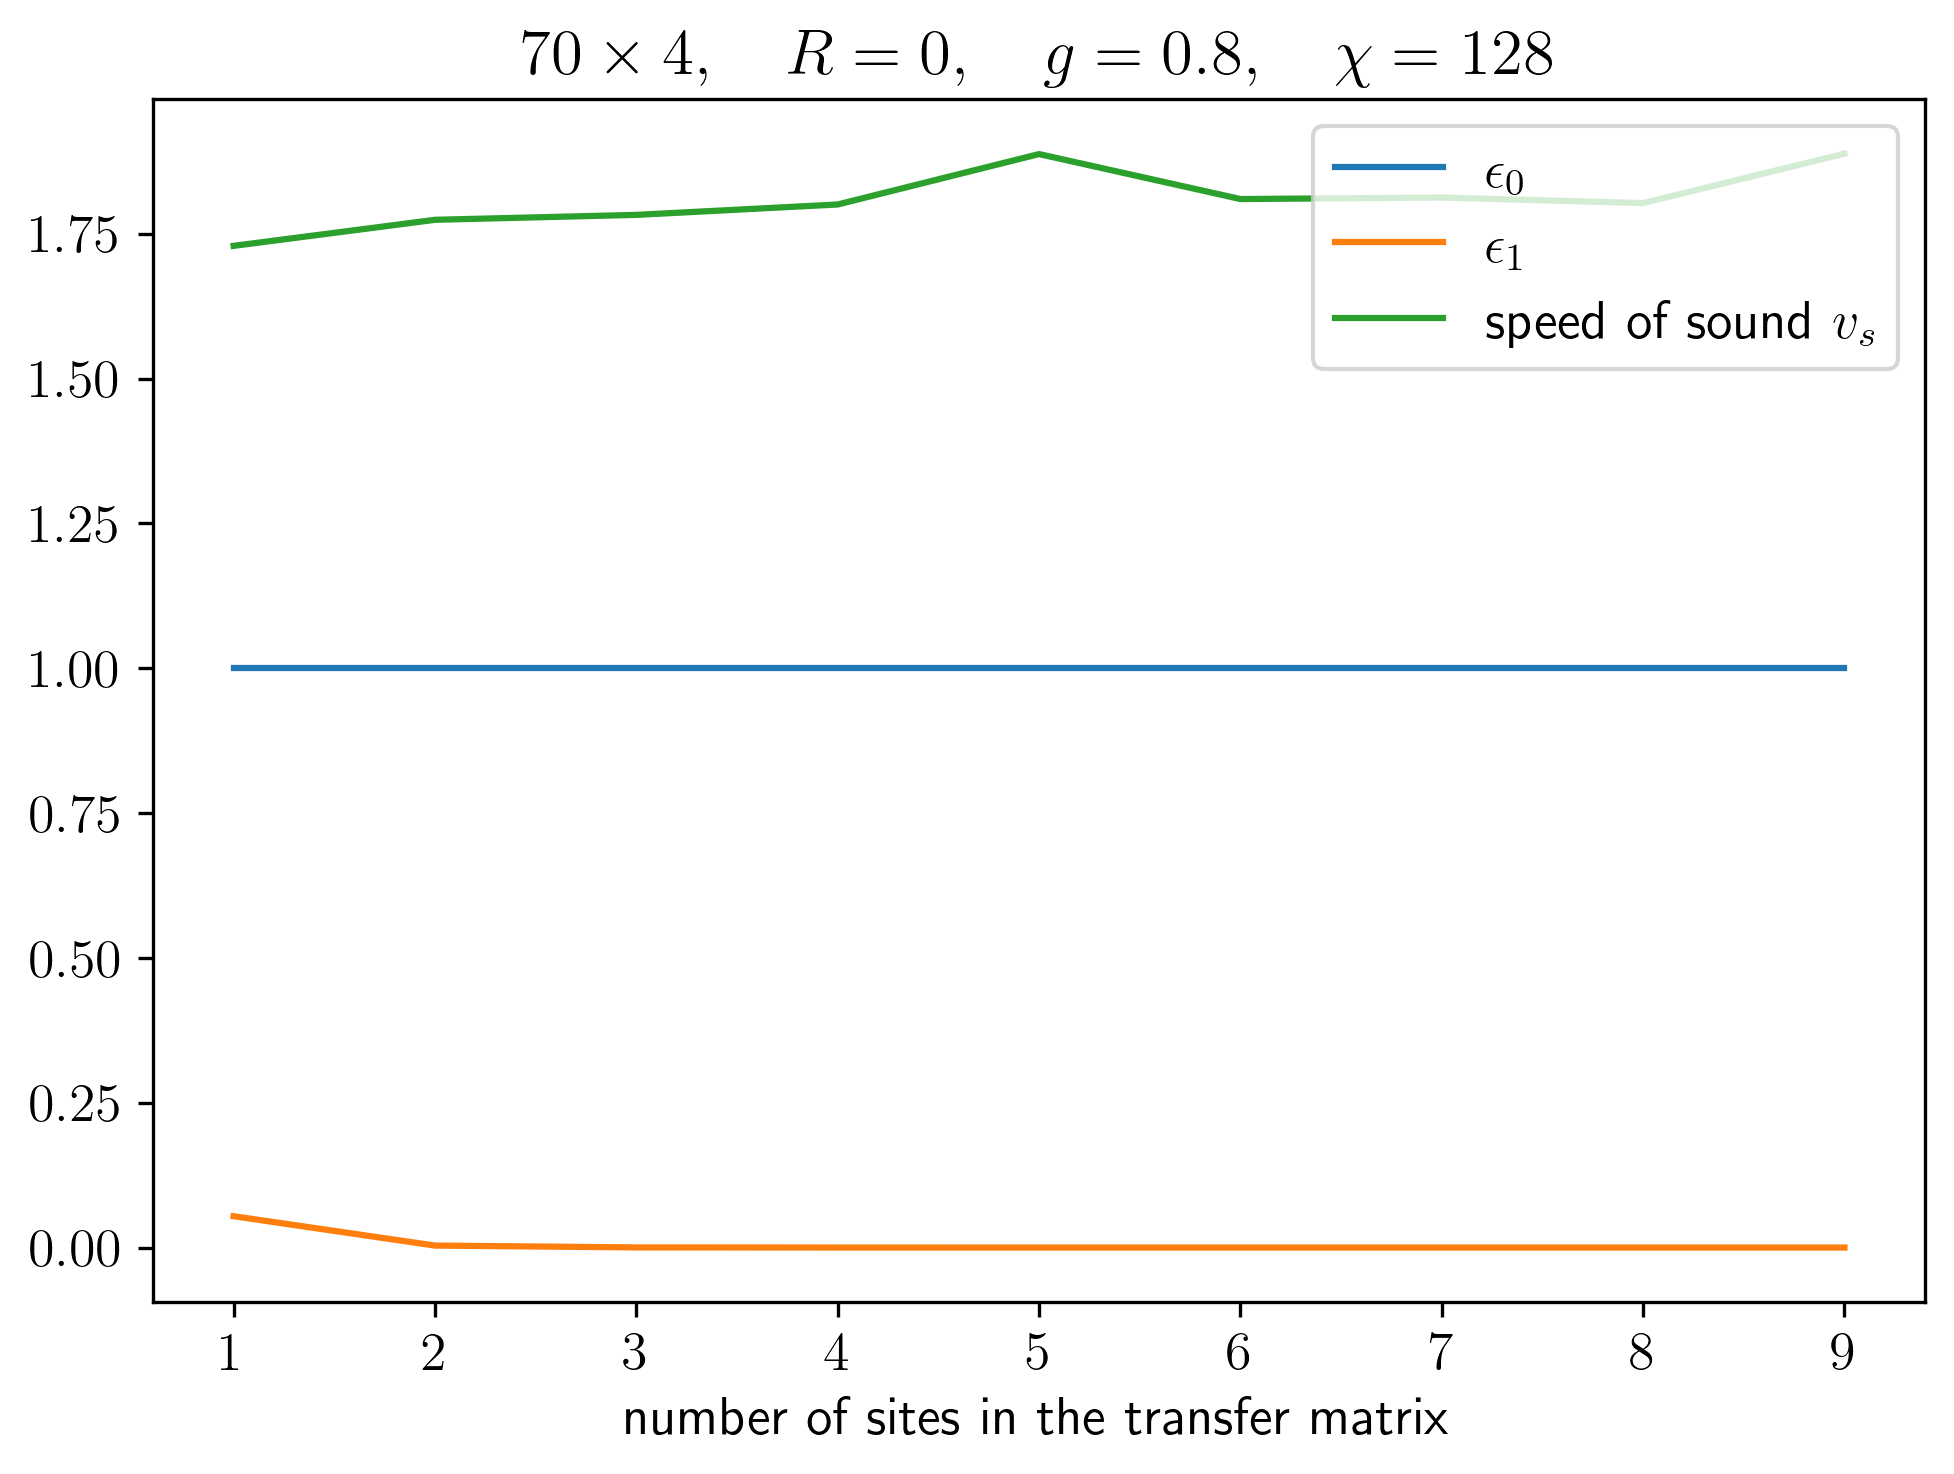

In [85]:
plt.plot(range(1,len(vs)+1), np.abs(np.asarray(energies)[:,0]), label="$\epsilon_0$")
plt.plot(range(1,len(vs)+1), np.abs(np.asarray(energies)[:,1]), label="$\epsilon_1$")
plt.plot(range(1,len(vs)+1), vs, label="speed of sound $v_s$")
plt.xlabel("number of sites in the transfer matrix")
plt.title(f"${L}\\times{N}, \\quad R={R}, \\quad g={g}, \\quad \\chi={chi}$")
plt.legend()
plt.savefig(f"{path_figures}/figures/energy/speed_of_sound_{N}x{L}_R_{R}_g_{g}_chi_{chi}.png")

In [ ]:
L = 70
N = 4
d = 2**N
chi = 192
R = 30
cx = get_cx(L, R)
cy = get_cy(N, bc, R=R)
# cx = np.nan
# cy = np.nan

linop = True
h_i, h_f, npoints = 0.6, 1.0, 9
gs = np.linspace(h_i,h_f,npoints).tolist()

if R == 0:
    sector = "vacuum_sector"
    try:
        e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        h_i, h_f, npoints = 0.6, 1.0, 9
        e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    except:
        e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
else:
    sector = "2_particle(s)_sector"
    e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    
velocities = []
for g in gs:
    lattice = MPS(L=L, d=d, model=model, chi=chi, h=g, bc=bc)
    if R != 0:
        lattice.Z2.add_charges(cx,cy)
        lattice.Z2._define_sector()
    lattice.load_sites(path, precision=3, cx=cx, cy=cy)

    energies = []
    end = 10
    tm = None
    for sites in range(1,end):
        print(f"computing a {sites} site(s) transfer matrix...")
        tm = multi_site_mps_transfer_matrix(sites, mps_tm=tm, linop=linop)
        print(f"transfer matrix found. Shape is {tm.shape}")
        if linop:
            e1 = get_tm_eigs(tm)
        else:
            e1, v1 = diagonalization(tm, sparse=True, k=2, which='LA')
        energies.append(e1)
    
    if linop:
        energies = [np.sort(e1)[::-1] for e1 in energies]
    corr_lens = np.array([-(i+1)/np.log(np.abs(np.asarray(energies)[i,1])) for i in range(len(energies))])

    idx = gs.index(g)
    vs = (e1_mps - e0_mps)[idx] * corr_lens
    velocities.append(vs)

In [ ]:
np.asarray(velocities).T

array([[0.42484602, 1.01410687, 1.10257287, 1.88556826, 1.84448805,
        1.76264182, 1.60181011, 1.9637547 , 1.82451507],
       [1.06390647, 1.43633167, 1.31545171, 1.69570179, 1.66990904,
        1.78681894, 1.71281322, 1.93682274, 1.95681187],
       [0.49235554, 1.67201397, 1.41095022, 1.73845988, 1.79681153,
        1.89818667, 1.8475554 , 1.97368249, 1.96196136],
       [0.96205845, 1.09696992, 1.67345839, 1.72474543, 1.6976603 ,
        1.81811392, 1.86337849, 1.85209902, 1.88666064],
       [0.6974245 , 1.30216892, 1.84575392, 1.58195571, 1.7856432 ,
        1.83268937, 1.84628084, 1.76985561, 1.99249893],
       [0.85703209, 1.32587431, 1.73310719, 1.61353809, 1.59742713,
        1.86485782, 1.86681282, 1.976875  , 1.94566596],
       [1.38026807, 1.33597519, 1.71726201, 1.67152818, 1.72285749,
        1.87496547, 1.9018062 , 1.90720227, 1.79843498],
       [0.88616815, 1.4168296 , 1.85097281, 1.57286164, 1.915636  ,
        1.9418444 , 1.86530188, 1.88780106, 1.95118858],


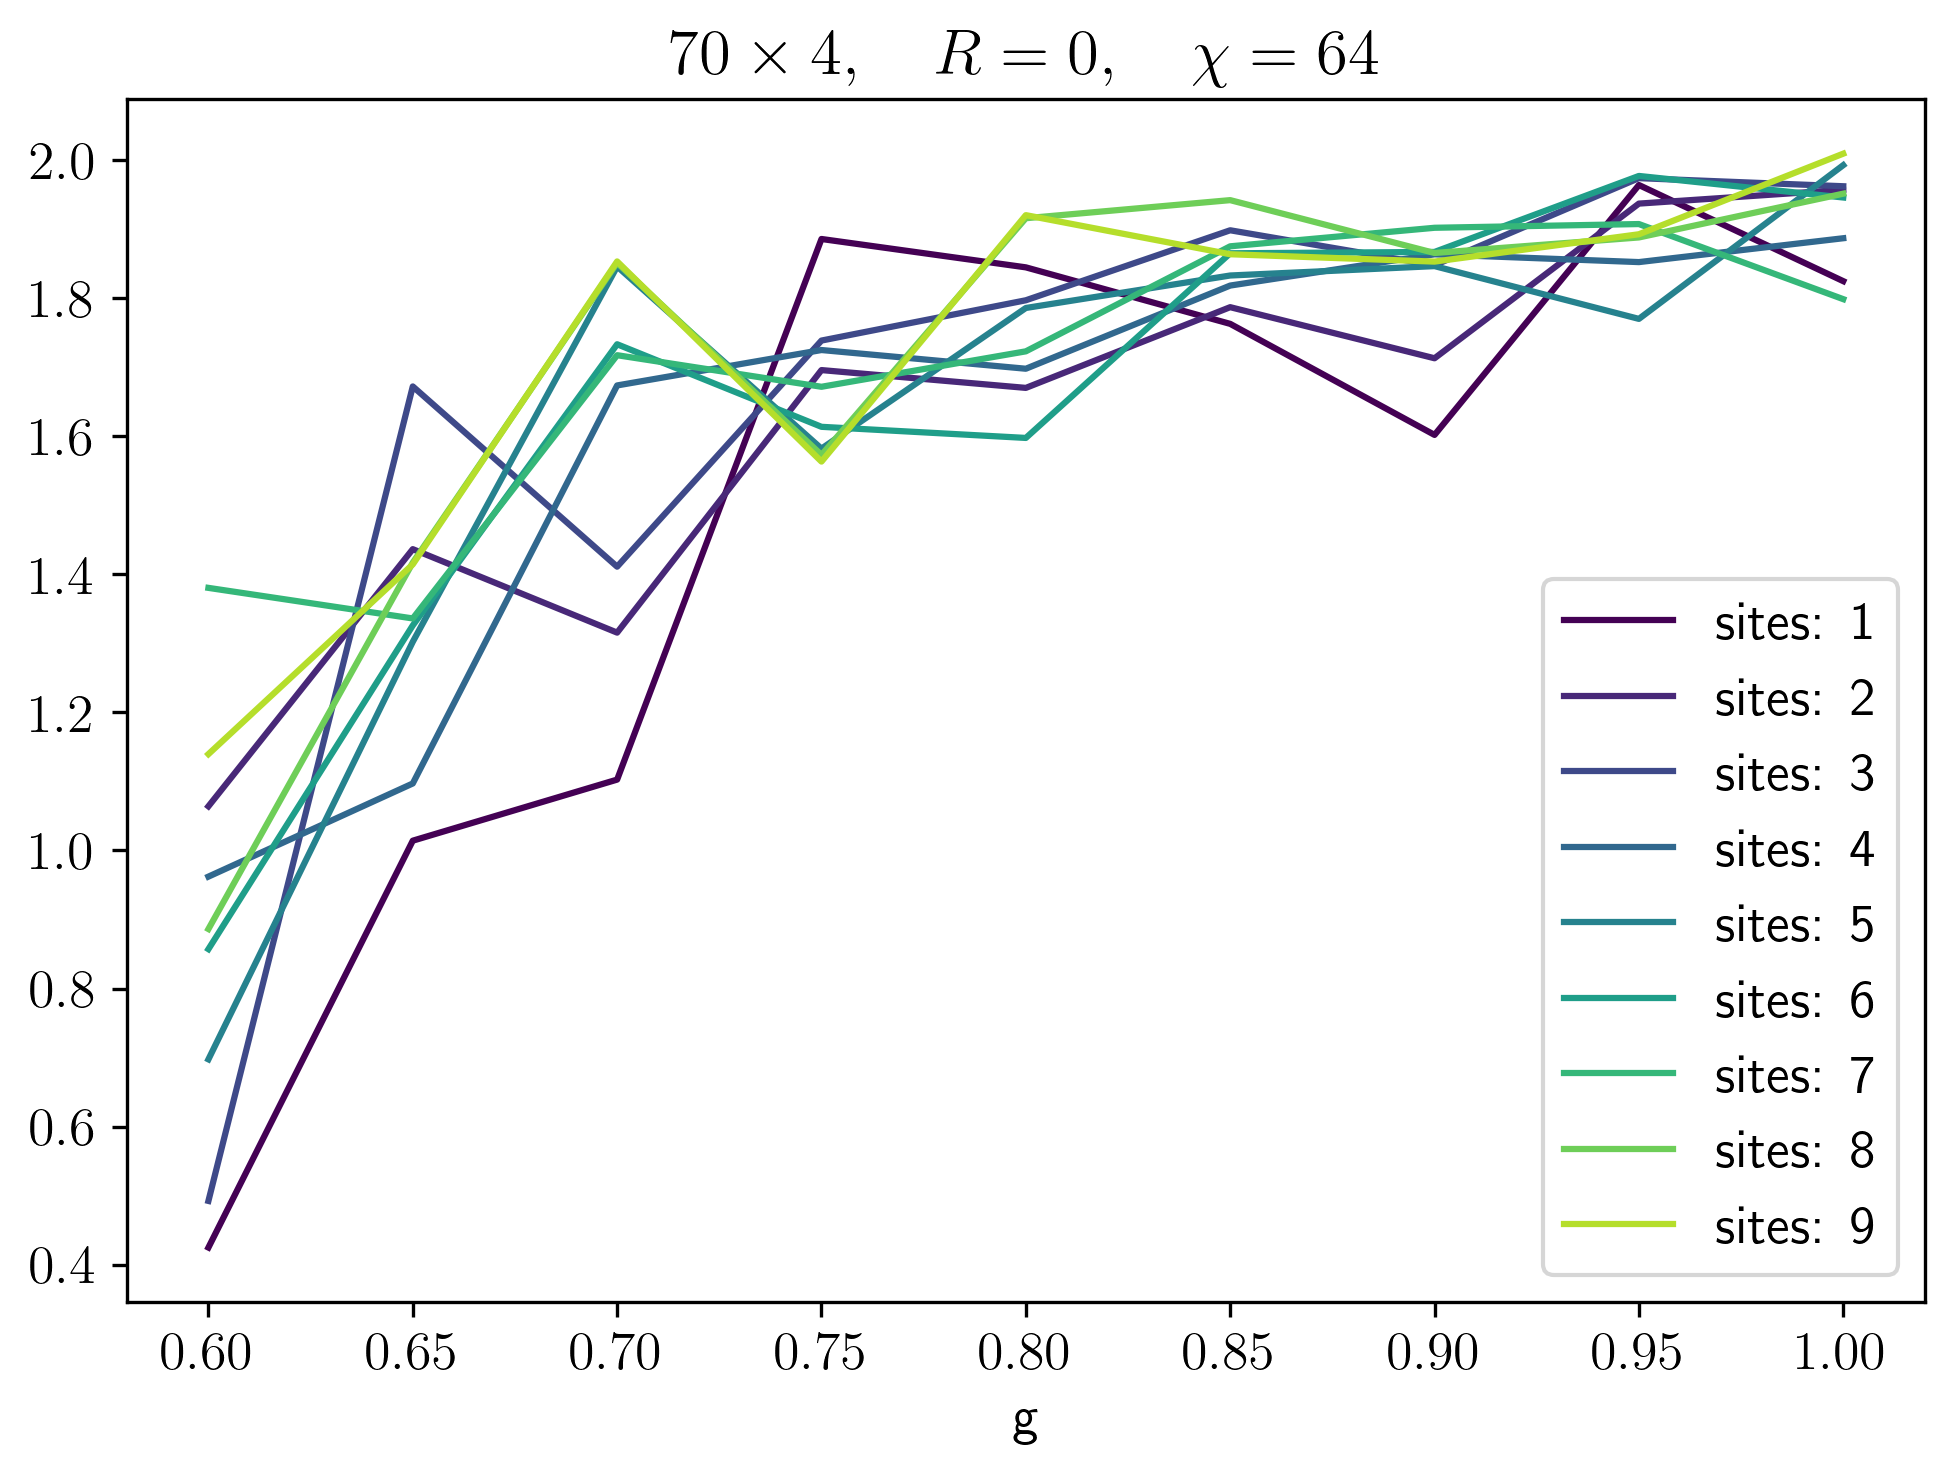

In [ ]:
colors = create_sequential_colors(end)
for i, vs in enumerate(np.asarray(velocities).T):
    plt.plot(gs, vs, color=colors[i], label=f"sites: {i+1}")
plt.xlabel("g")
plt.title(f"${L}\\times{N}, \\quad R={R}, \\quad \\chi={chi}$")
plt.legend()
plt.savefig(f"{path_figures}/figures/energy/speed_of_sound_vs_g_{N}x{L}_R_{R}_{h_i}-{h_f}_npoints_{npoints}_chi_{chi}.png")

In [32]:
def get_speed_of_sound(cx, cy, chi):
    if type(cx) == float:
        sector = "vacuum_sector"
        try:
            velocities = np.load(f"{path}/results/energy_data/speed_of_sound_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        except:
            velocities = np.load(f"{path}/results/energy_data/speed_of_sound_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    else:
        sector = "2_particle(s)_sector"
        velocities = np.load(f"{path}/results/energy_data/speed_of_sound_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    return velocities

In [41]:
L = 70
N = 4
chi = 96
h_i, h_f, npoints = 0.6, 1.0, 9
gs = np.linspace(h_i,h_f,npoints).tolist()

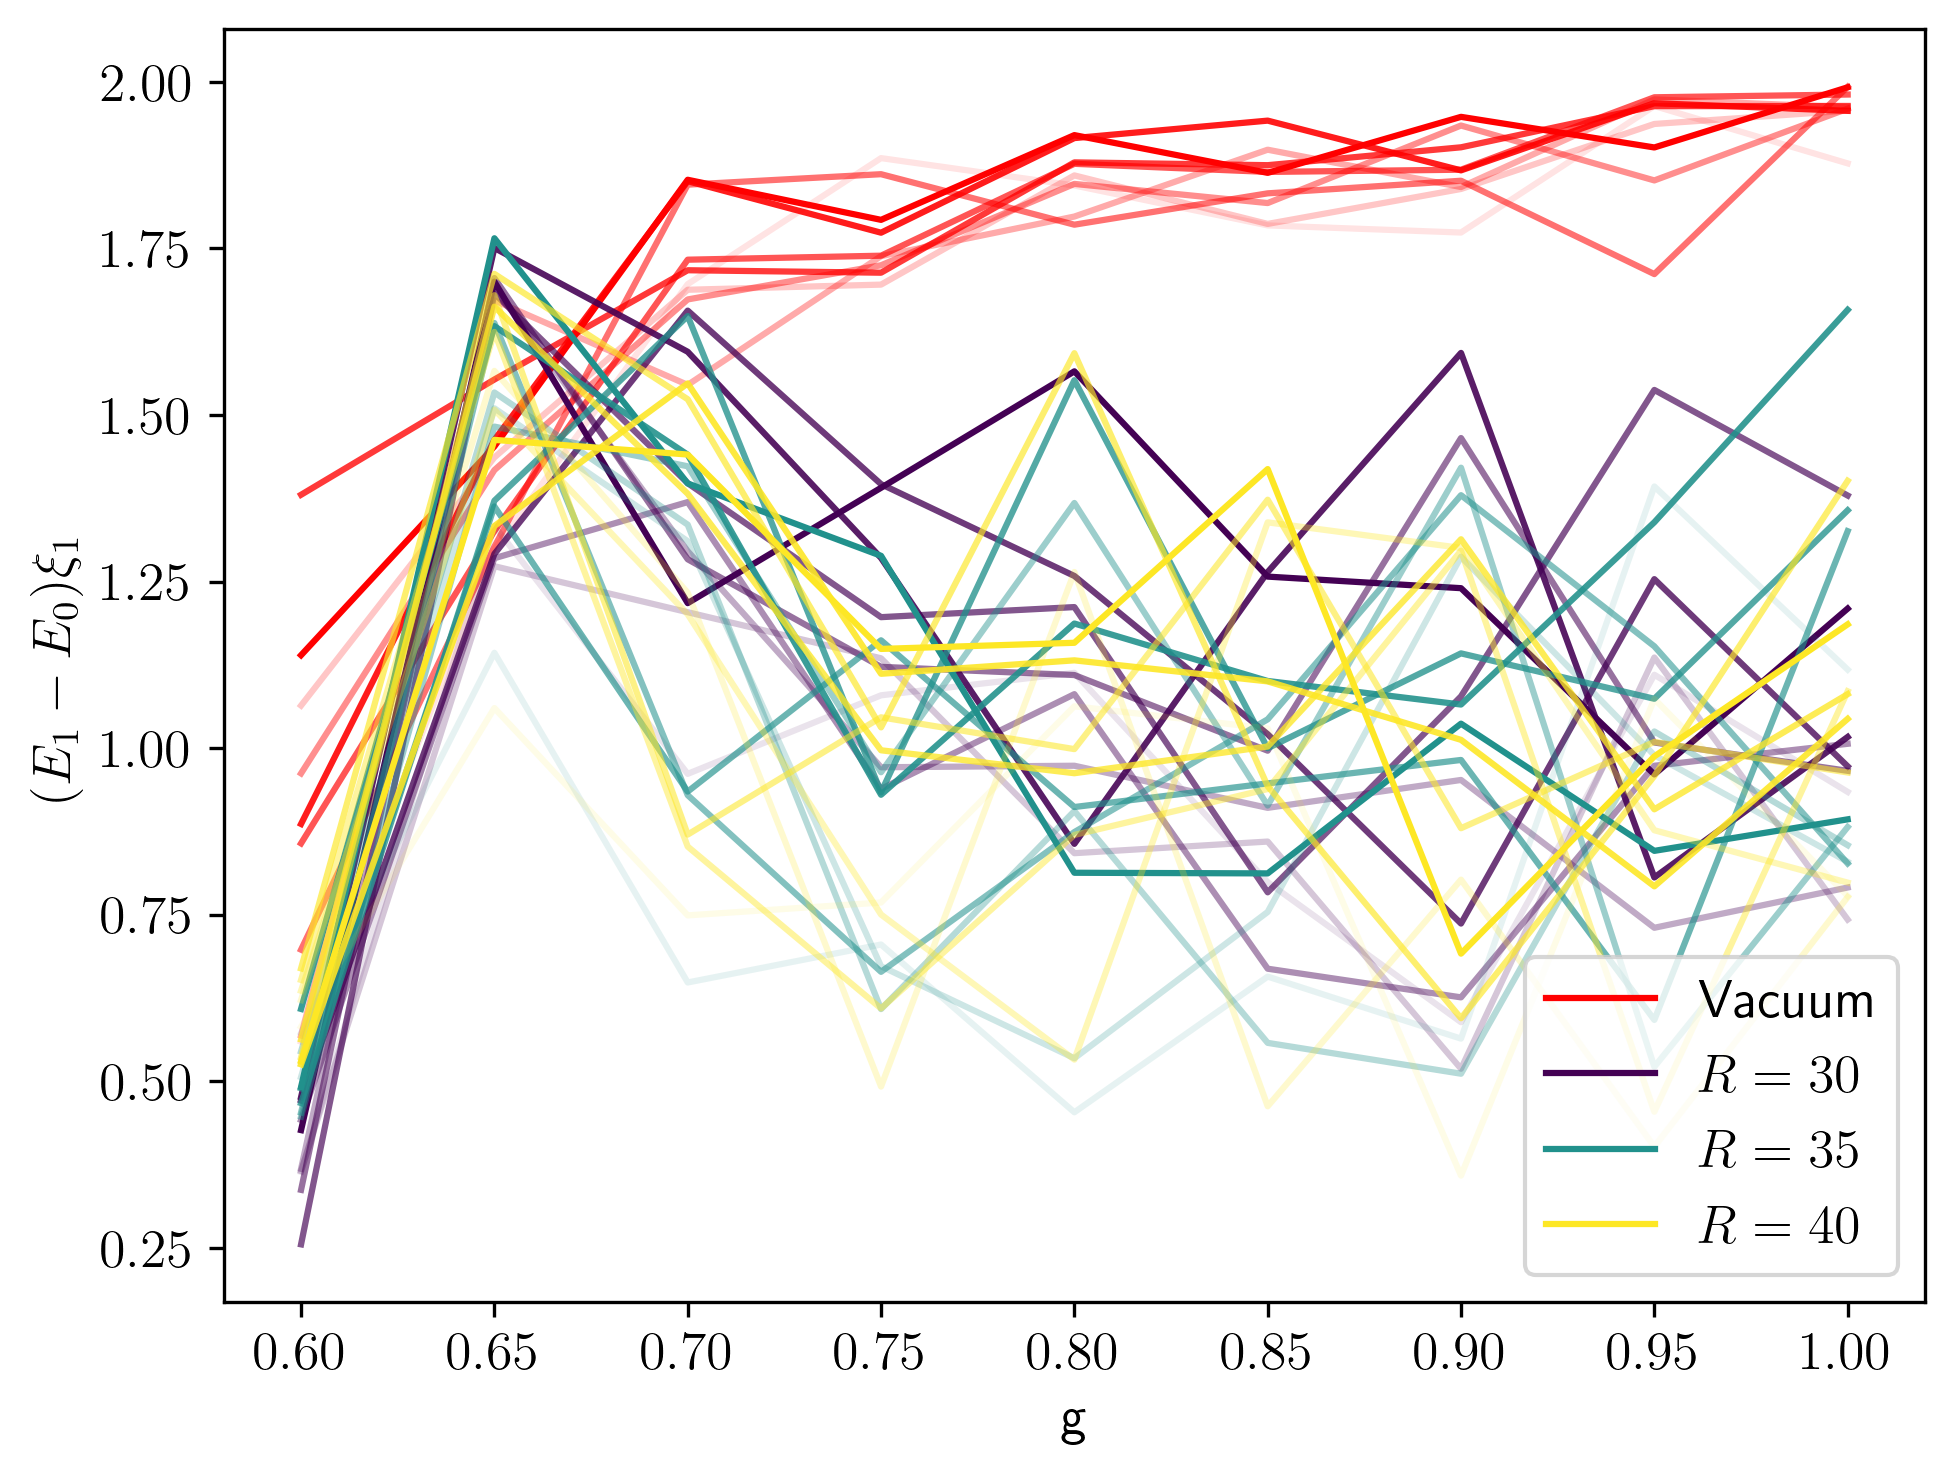

In [ ]:
cx = np.nan
cy = np.nan
chi = 64

vs = get_speed_of_sound(cx,cy,chi)
for i, v in enumerate(vs):
    if i == (len(vs)-1):
        label= f"Vacuum"
    else:
        label=None
    plt.plot(gs, v, color='red', alpha=(i+1)/len(vs), label=label)

chi = 96
Rs = [30,35,40]
colors = create_sequential_colors(len(Rs))
for k, R in enumerate(Rs):
    cx = get_cx(L, R)
    cy = get_cy(N, bc, R=R)
    vs = get_speed_of_sound(cx,cy,chi)

    for i, v in enumerate(vs):
        if i == (len(vs)-1):
            label= f"$R={R}$"
        else:
            label=None
        plt.plot(gs, v, color=colors[k], alpha=(i+1)/len(vs), label=label)

plt.xlabel("g")
plt.ylabel("$ (E_1-E_0) \\xi_1 $")
plt.legend()

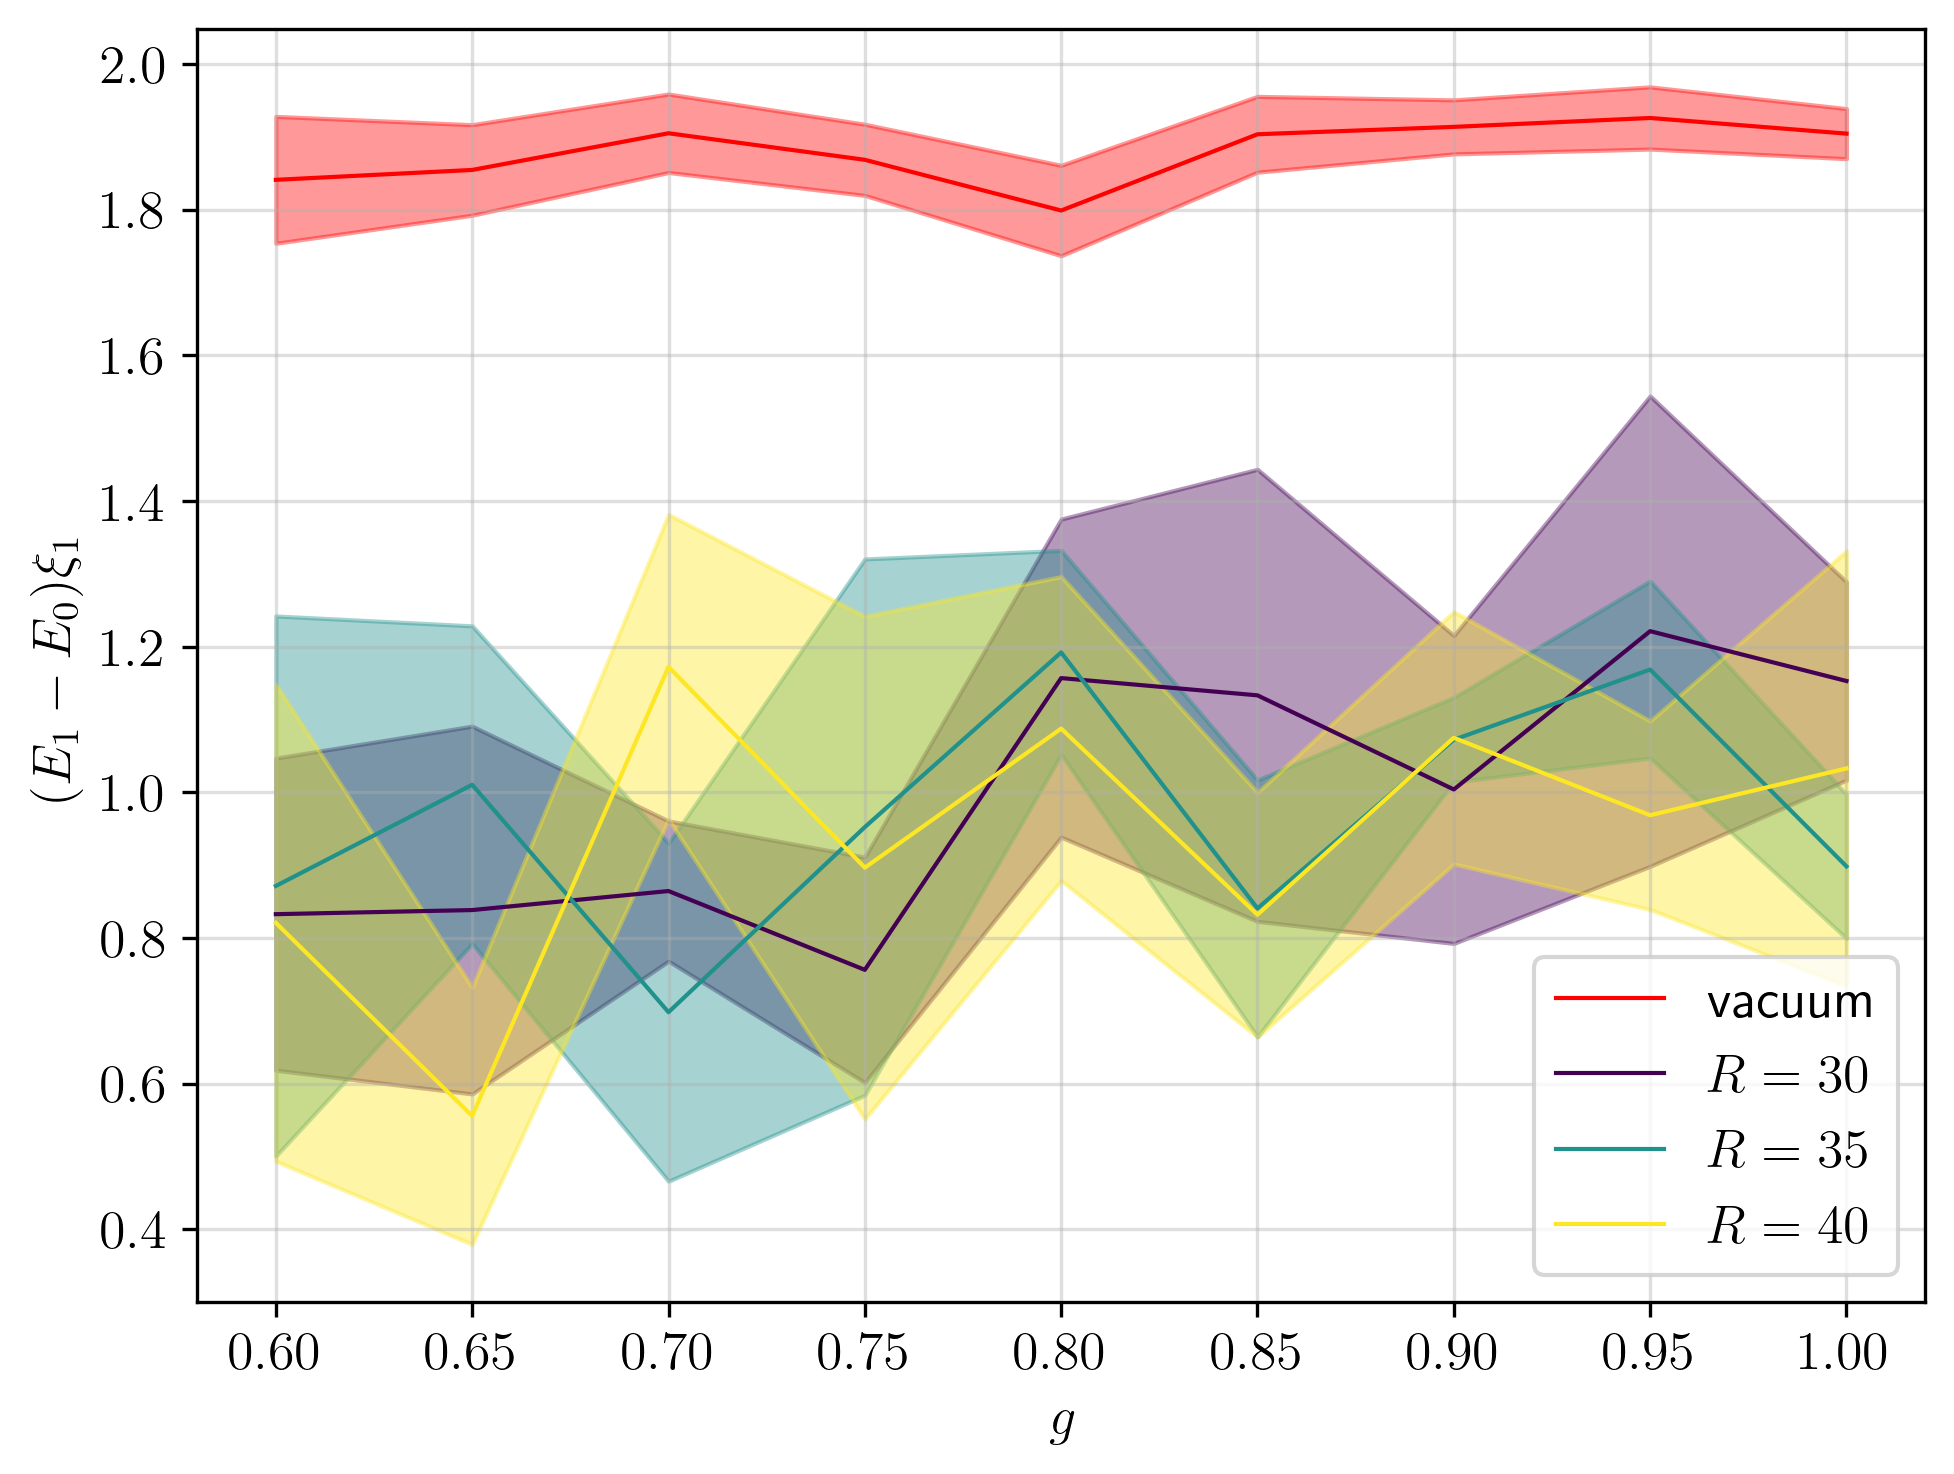

In [77]:
cx = np.nan
cy = np.nan
chi = 64

sites = [5,-1]
vs = get_speed_of_sound(cx,cy,chi)
vs_mean = np.mean(vs[:,sites[0]:sites[-1]], axis=1)
vs_std = np.std(vs[:,sites[0]:sites[-1]], axis=1)
plt.plot(gs, vs_mean, color='red', linewidth=1, label="vacuum")
plt.fill_between(gs, vs_mean+vs_std, vs_mean-vs_std, color='red', alpha=0.4)

chi = 96
Rs = [30,35,40]
colors = create_sequential_colors(len(Rs))
for k, R in enumerate(Rs):
    cx = get_cx(L, R)
    cy = get_cy(N, bc, R=R)
    vs = get_speed_of_sound(cx,cy,chi)
    vs_mean = np.mean(vs[:,sites[0]:sites[-1]], axis=1)
    vs_std = np.std(vs[:,sites[0]:sites[-1]], axis=1)
    plt.plot(gs, vs_mean, color=colors[k], linewidth=1, label=f"$R={R}$")
    plt.fill_between(gs, vs_mean+vs_std, vs_mean-vs_std, color=colors[k], alpha=0.4)


plt.grid(True, alpha=0.4)
plt.xlabel("$g$")
plt.ylabel("$ (E_1-E_0) \\xi_1 $")
plt.legend()

## Check sectors gaps

In [4]:
L = 70
N = 4
chi = 192
h_i, h_f, npoints = 0.6, 1.0, 9
gs = np.linspace(h_i,h_f,npoints).tolist()

In [5]:
def get_mass_gap(cx, cy, chi):
    if type(cx) == float:
        sector = "vacuum_sector"
        try:
            e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
            e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        except:
            e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
            e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    else:
        sector = "2_particle(s)_sector"
        e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    return e1_mps - e0_mps

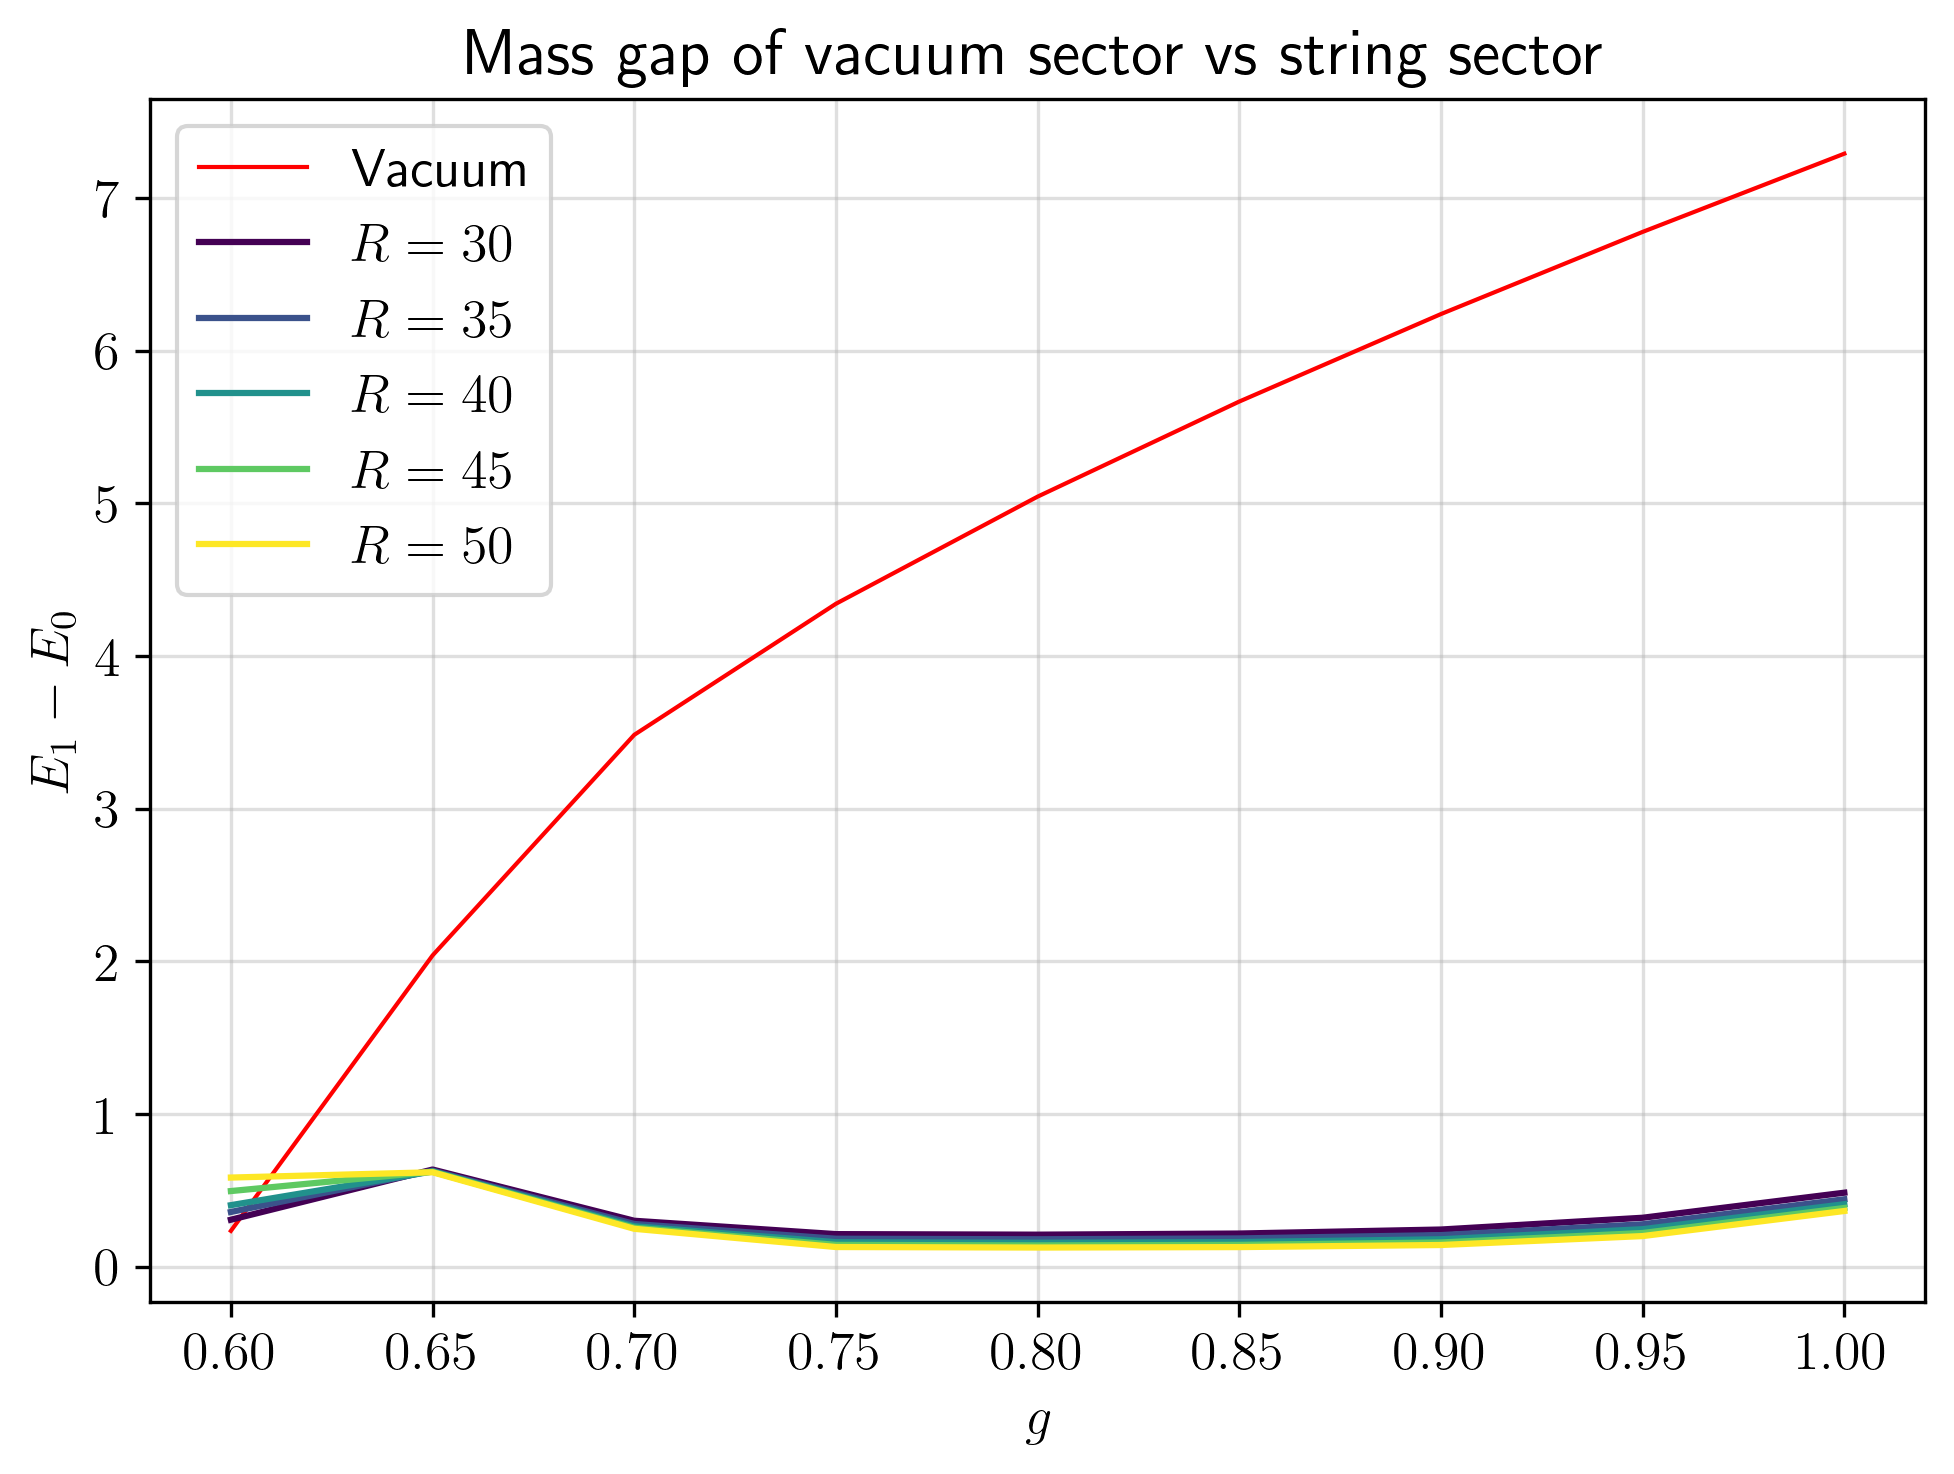

In [6]:
cx = np.nan
cy = np.nan
gap = get_mass_gap(cx,cy,chi)
plt.plot(gs, gap, color='red', linewidth=1, label="Vacuum")
Rs = [30,35,40,45,50]
colors = create_sequential_colors(len(Rs))
for i, R in enumerate(Rs):
    cx = get_cx(L, R)
    cy = get_cy(N, bc, R=R)
    gap = get_mass_gap(cx,cy,chi)
    plt.plot(gs, gap, color=colors[i], label=f"$R={R}$")
plt.grid(True, alpha=0.4)
plt.title("Mass gap of vacuum sector vs string sector")
plt.xlabel("$g$")
plt.ylabel("$E_1 - E_0$")
plt.legend()

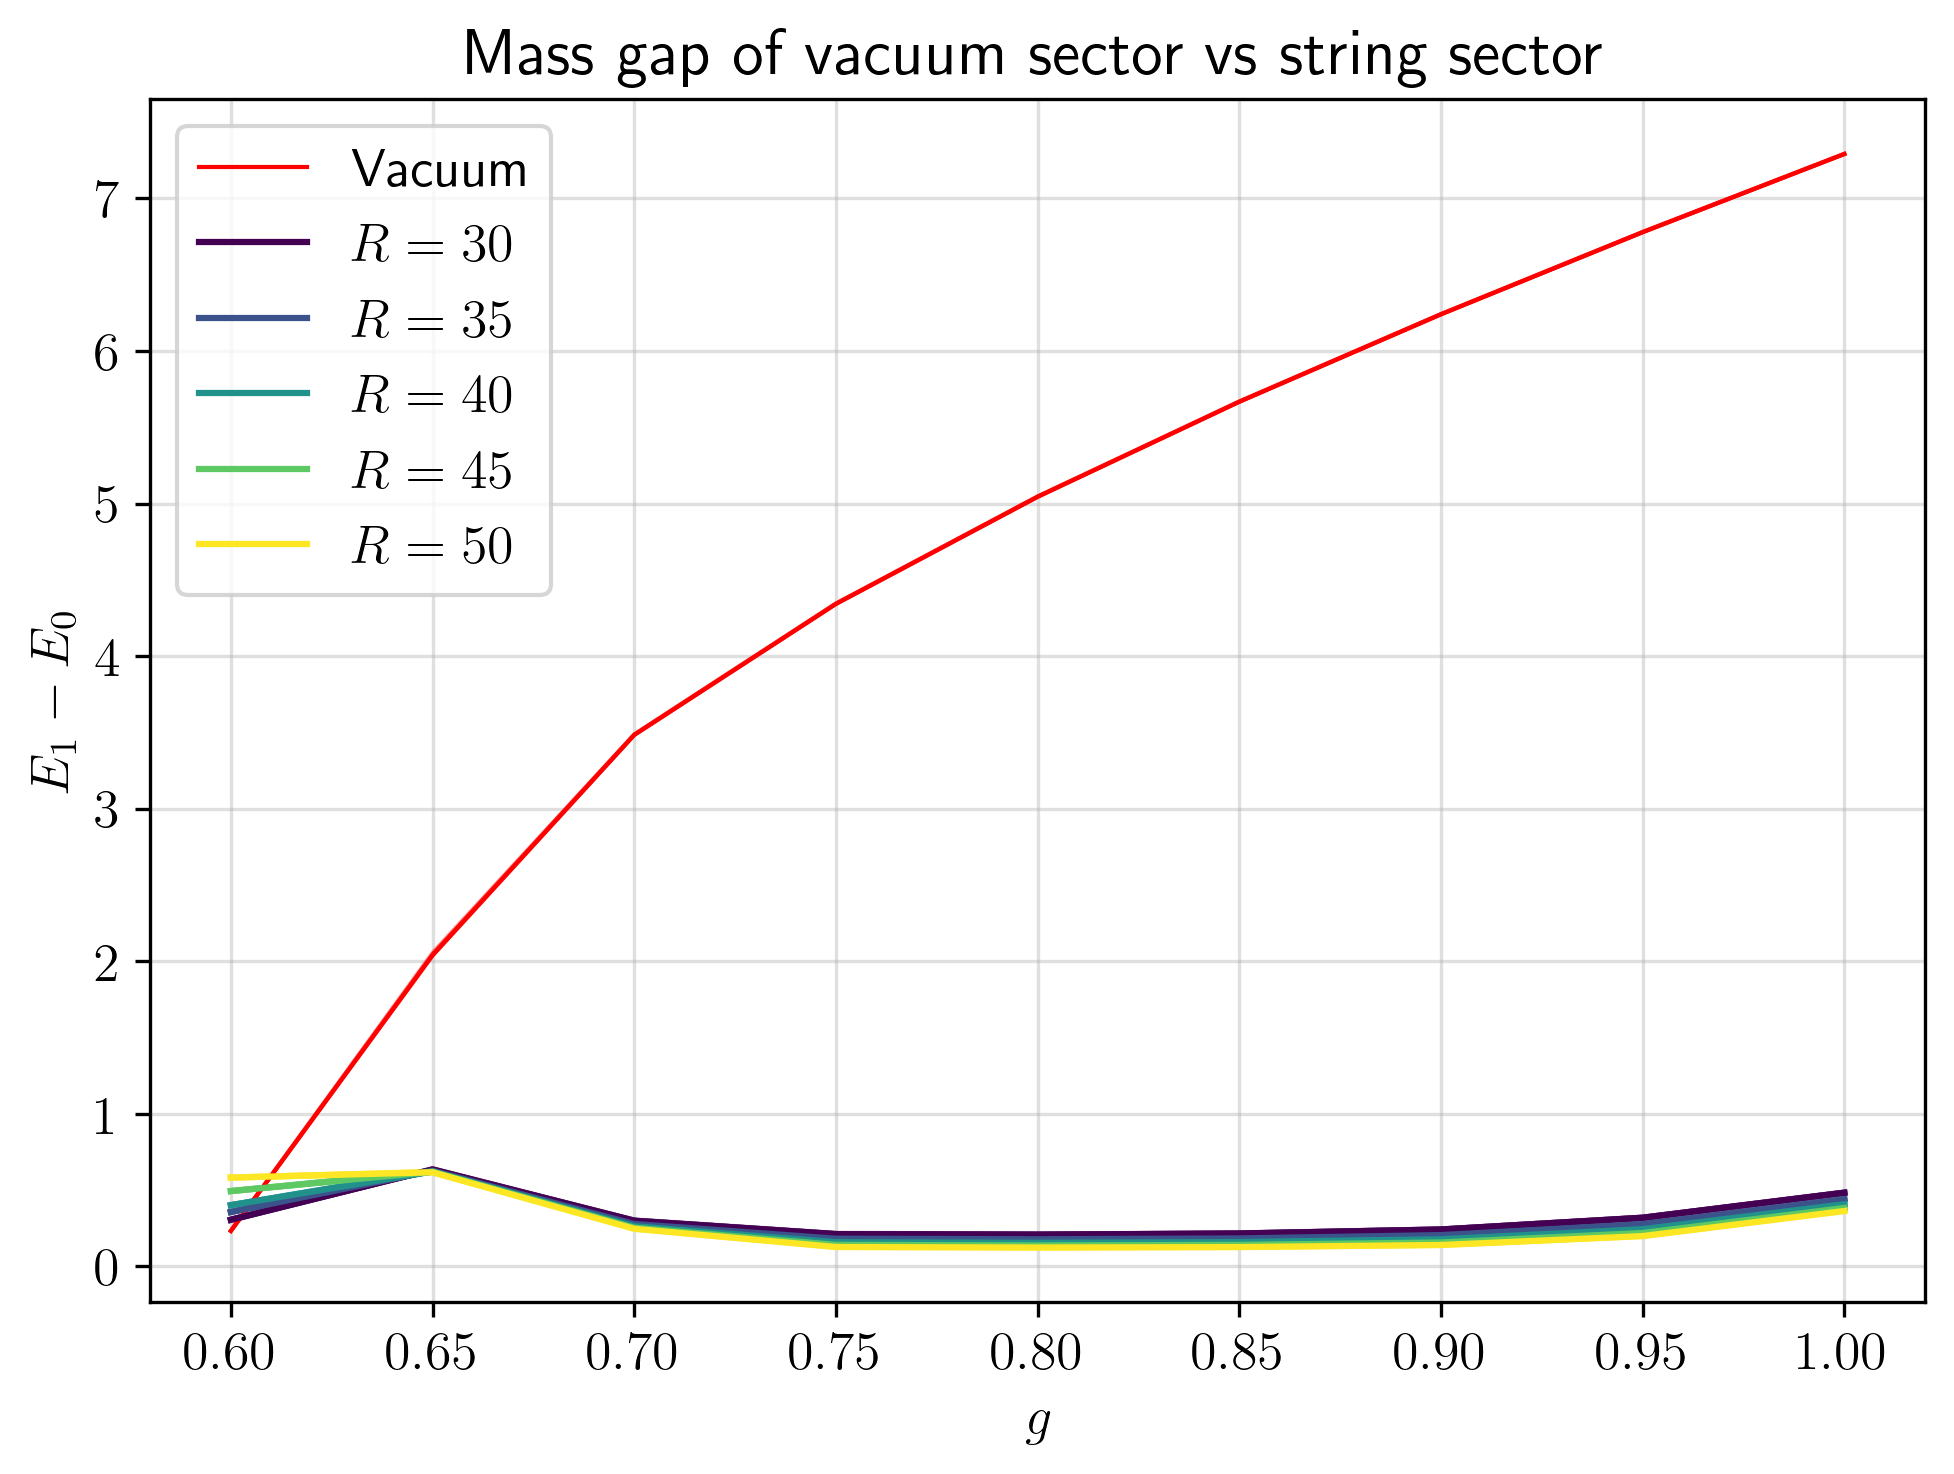

In [7]:
chis = [64,96,128,192]
for a, chi in enumerate(chis):
    cx = np.nan
    cy = np.nan
    gap = get_mass_gap(cx,cy,chi)
    if a == (len(chis)-1):
        label= "Vacuum"
    else:
        label=None
    plt.plot(gs, gap, color='red', linewidth=1, alpha=(a+1)/len(chis), label=label)
    Rs = [30,35,40,45,50]
    colors = create_sequential_colors(len(Rs))
    for i, R in enumerate(Rs):
        cx = get_cx(L, R)
        cy = get_cy(N, bc, R=R)
        gap = get_mass_gap(cx,cy,chi)
        if a == (len(chis)-1):
            label= f"$R={R}$"
        else:
            label=None
        plt.plot(gs, gap, color=colors[i], alpha=(a+1)/len(chis), label=label)
plt.grid(True, alpha=0.4)
plt.title("Mass gap of vacuum sector vs string sector")
plt.xlabel("$g$")
plt.ylabel("$E_1 - E_0$")
plt.legend()

### Vacuum gap with $\chi$

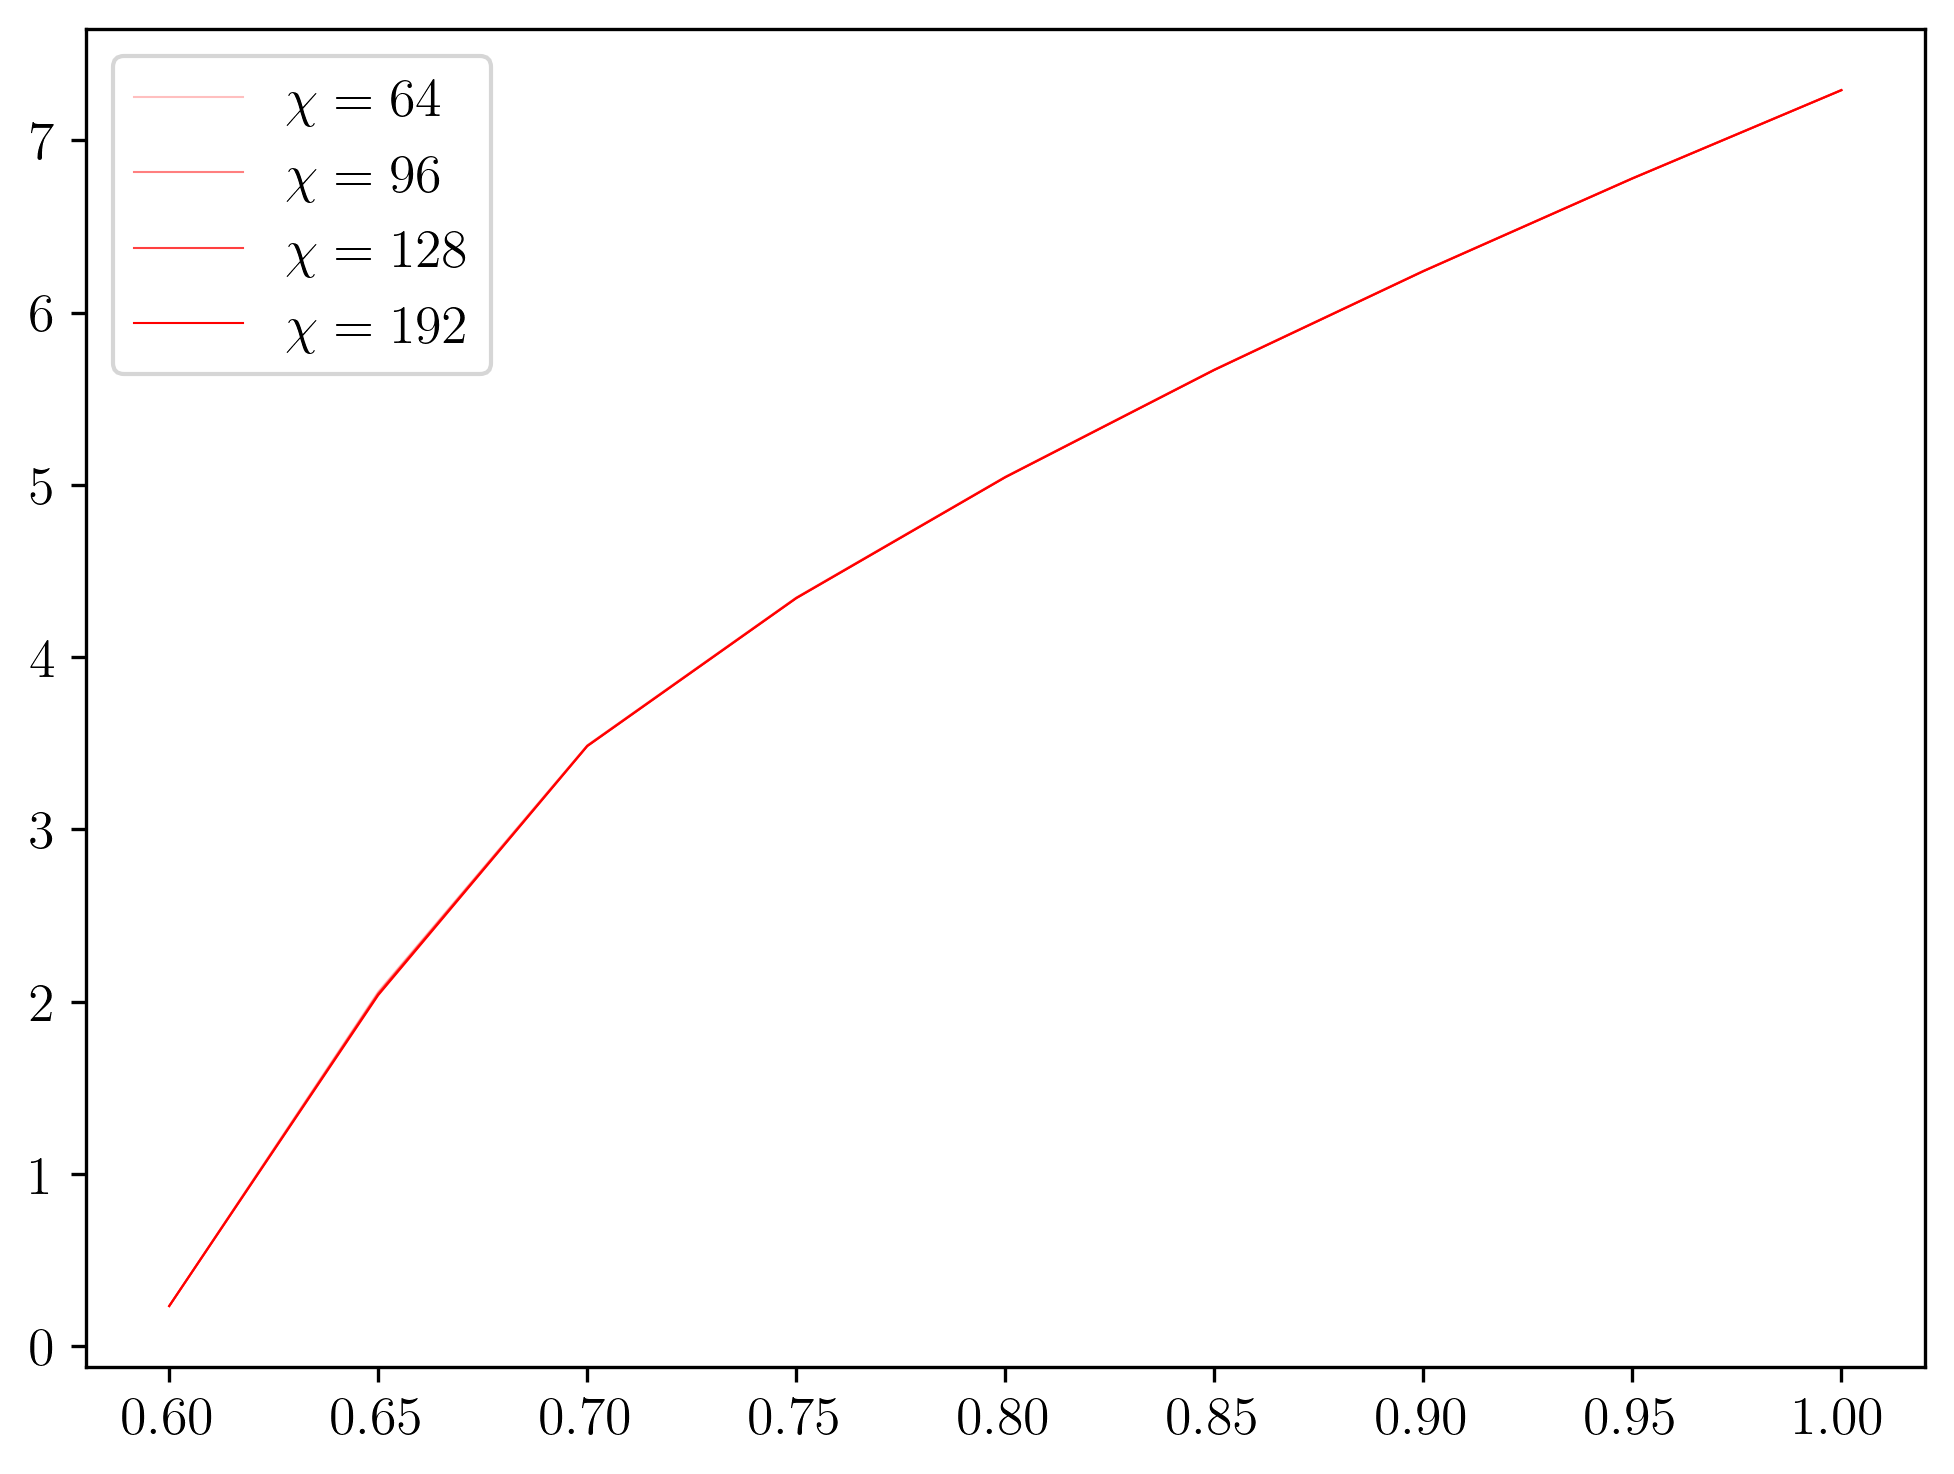

In [18]:
gaps = []
for a, chi in enumerate(chis):
    cx = np.nan
    cy = np.nan
    gap = get_mass_gap(cx,cy,chi)
    gaps.append(gap)
    plt.plot(gs, gap, color='red', linewidth=0.5, alpha=(a+1)/len(chis), label=f"$\chi={chi}$")
plt.legend()

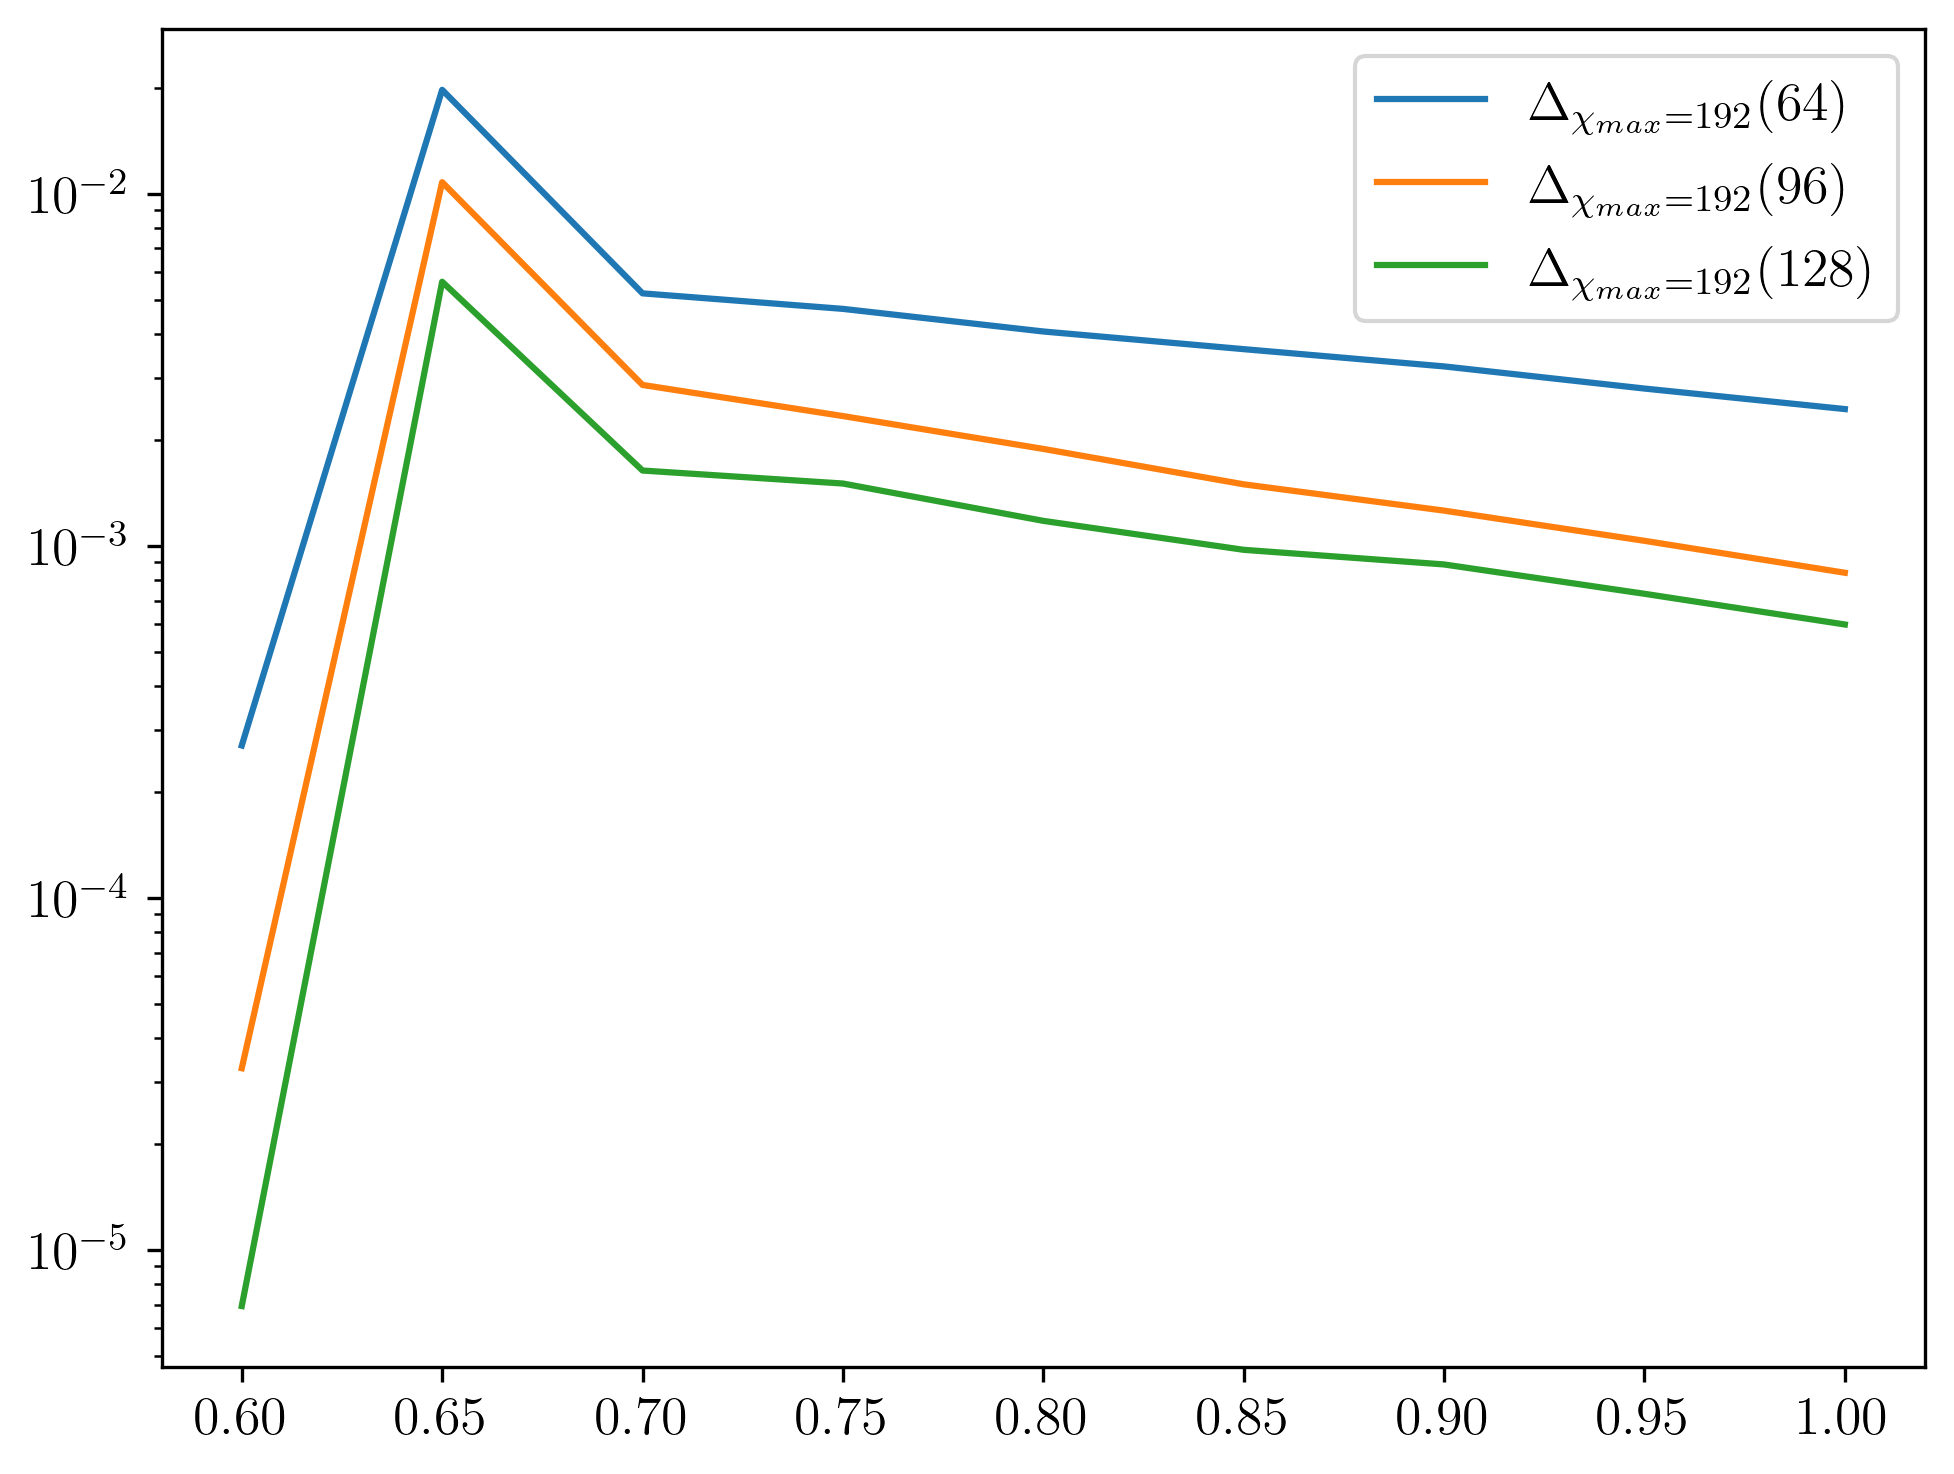

In [14]:
for i in range(len(gaps)-1):
    plt.plot(gs, np.abs(gaps[-1] - gaps[i]), label=f"$\Delta_{{\chi_{{max}}={chis[-1]}}}({chis[i]})$")
plt.legend()
plt.yscale("log")

### String gap with $\chi$

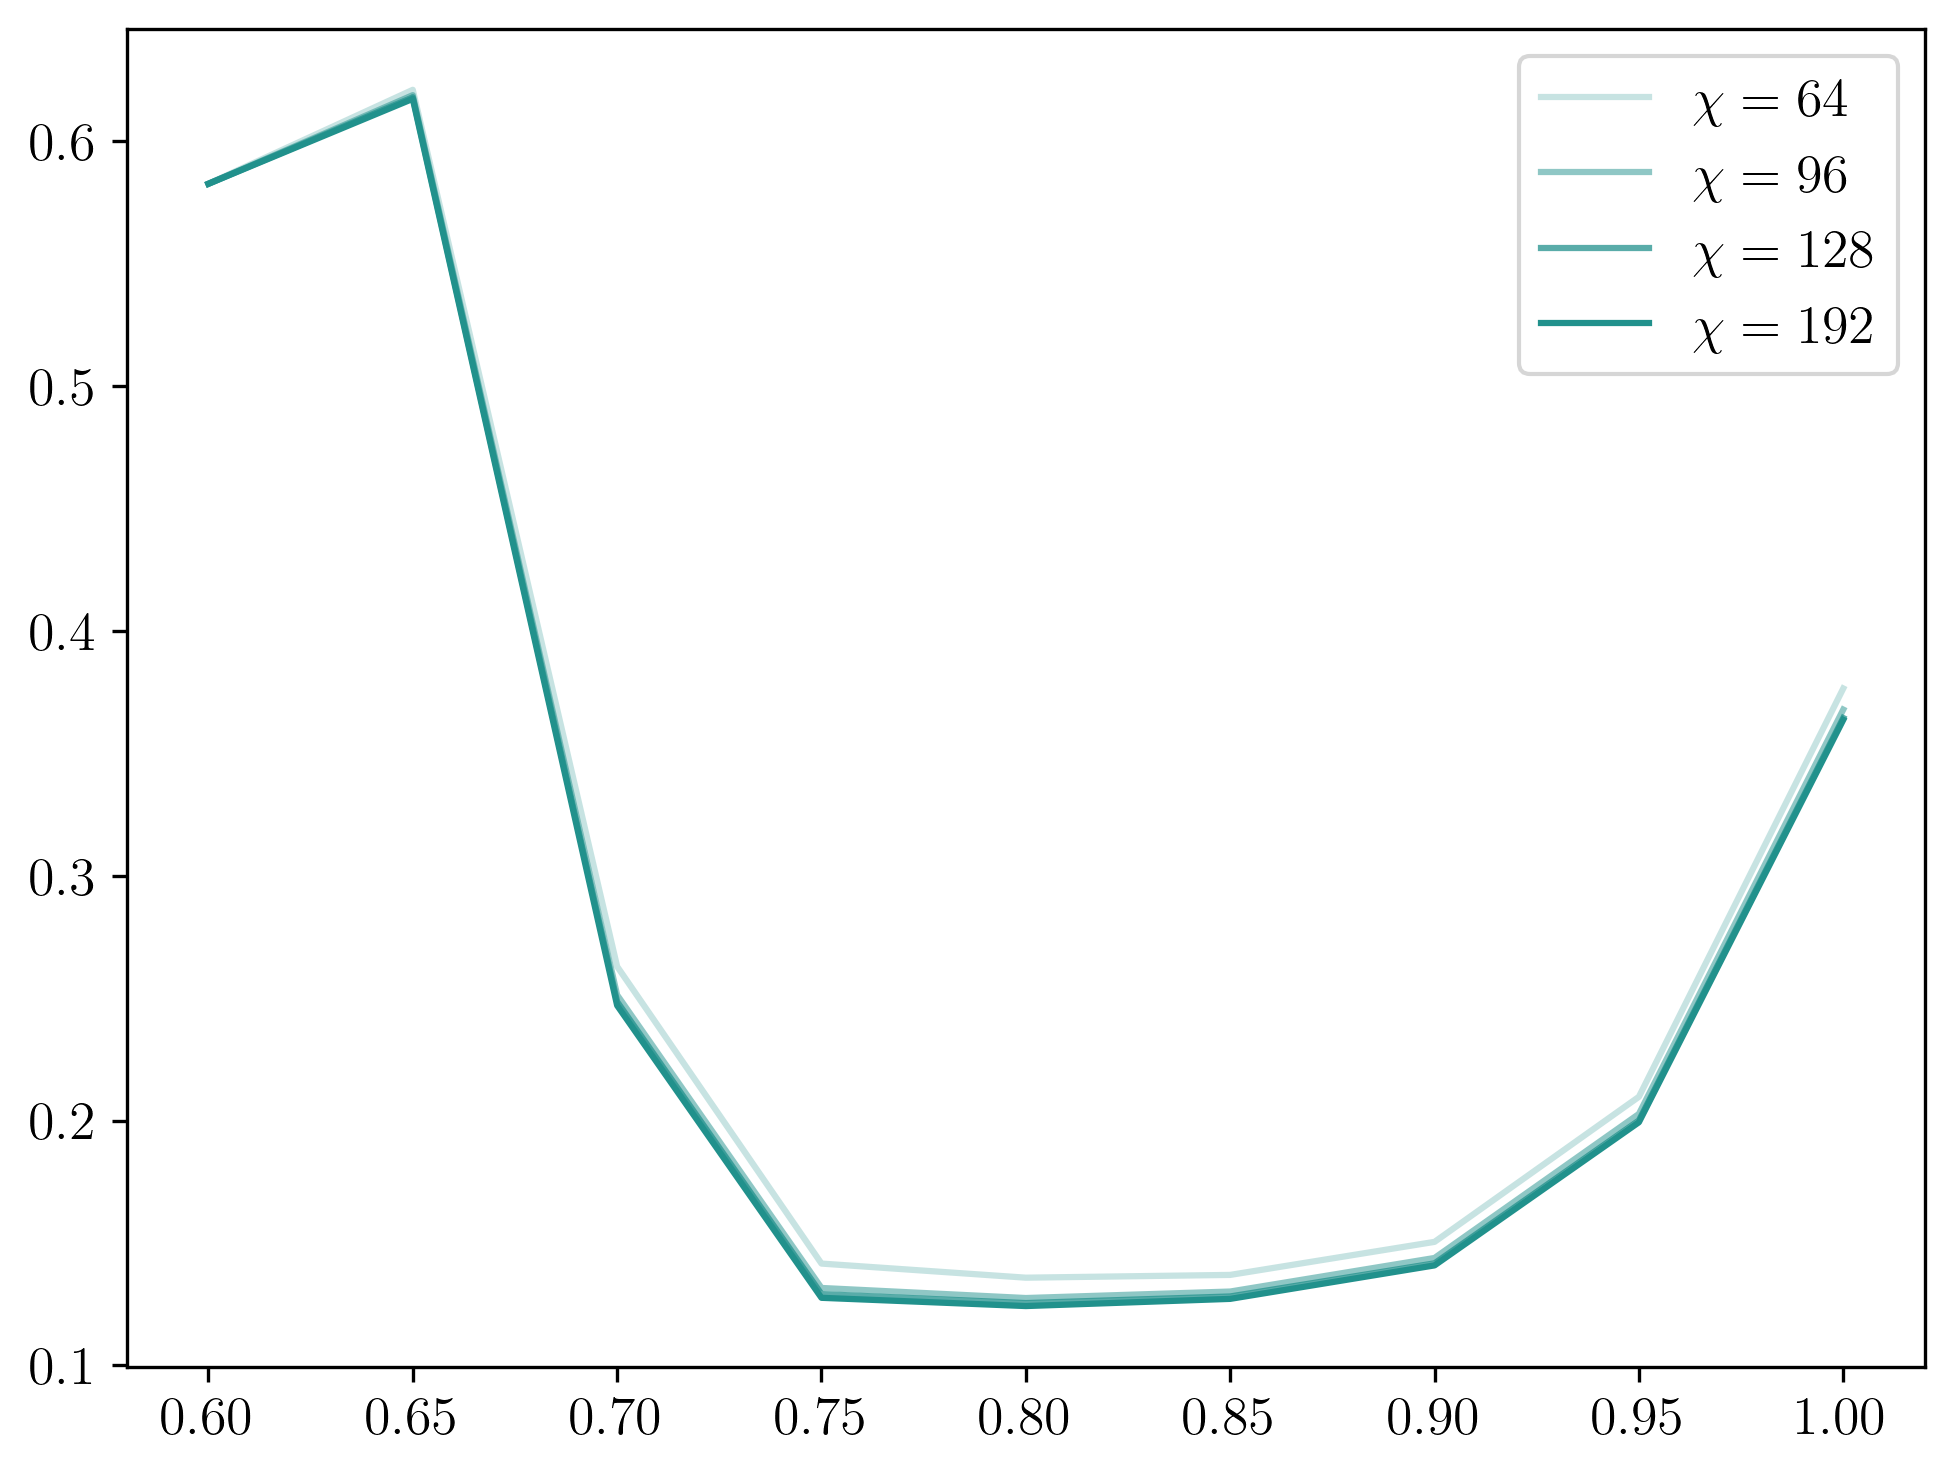

In [28]:
gaps = []
R = 50
for a, chi in enumerate(chis):
    cx = get_cx(L, R)
    cy = get_cy(N, bc, R=R)
    gap = get_mass_gap(cx,cy,chi)
    gaps.append(gap)
    plt.plot(gs, gap, color=colors[i], alpha=(a+1)/len(chis), label=f"$\chi={chi}$")
plt.legend()

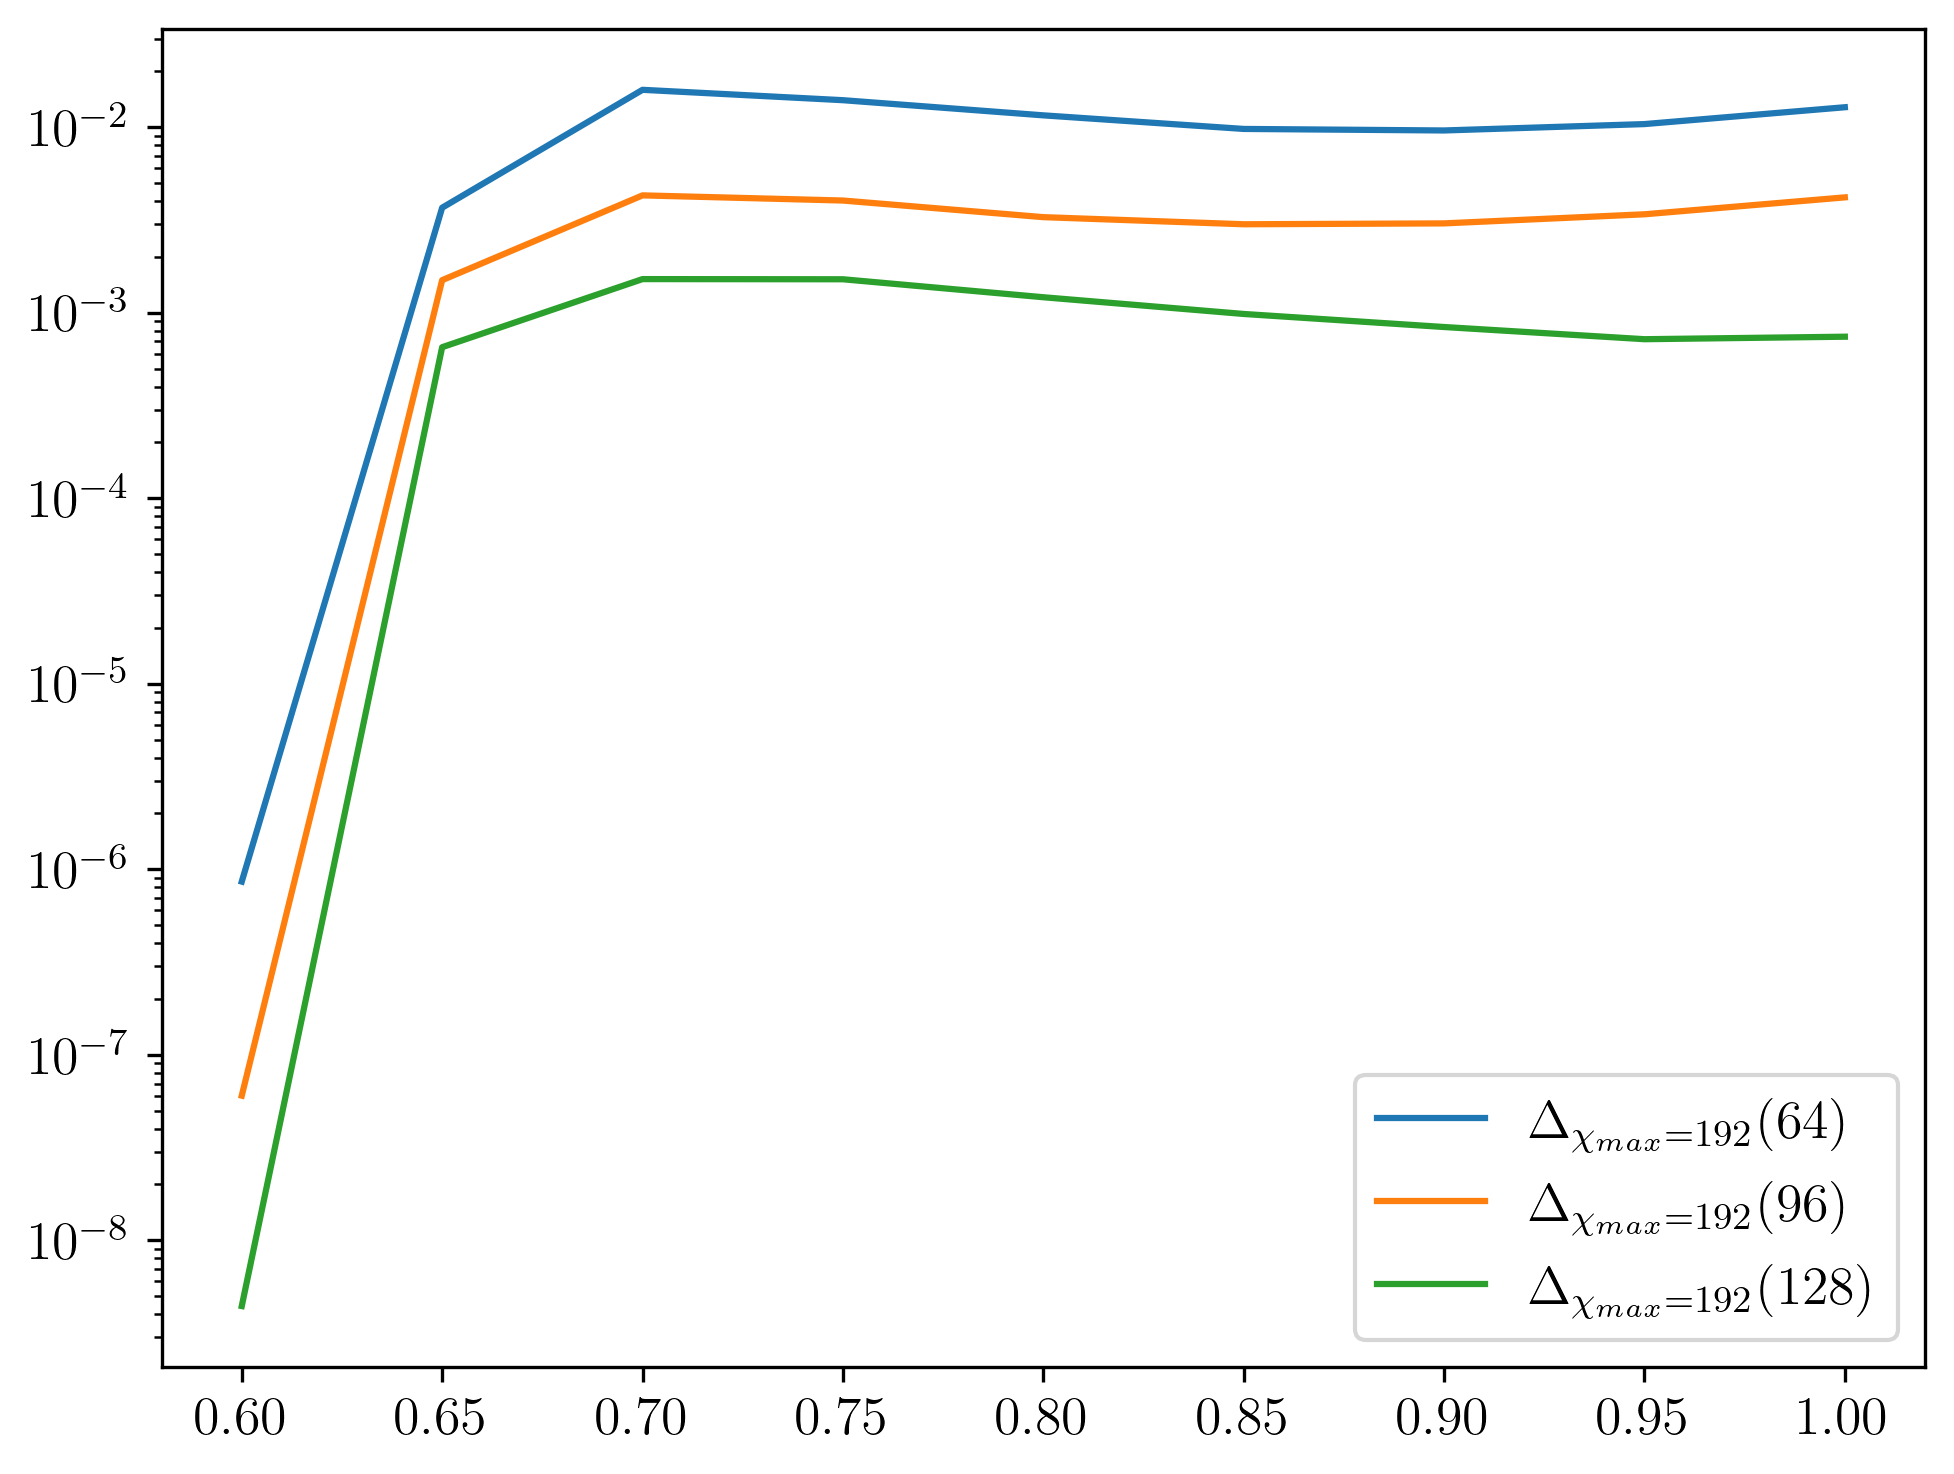

In [21]:
for i in range(len(gaps)-1):
    plt.plot(gs, np.abs(gaps[-1] - gaps[i]), label=f"$\Delta_{{\chi_{{max}}={chis[-1]}}}({chis[i]})$")
plt.legend()
plt.yscale("log")

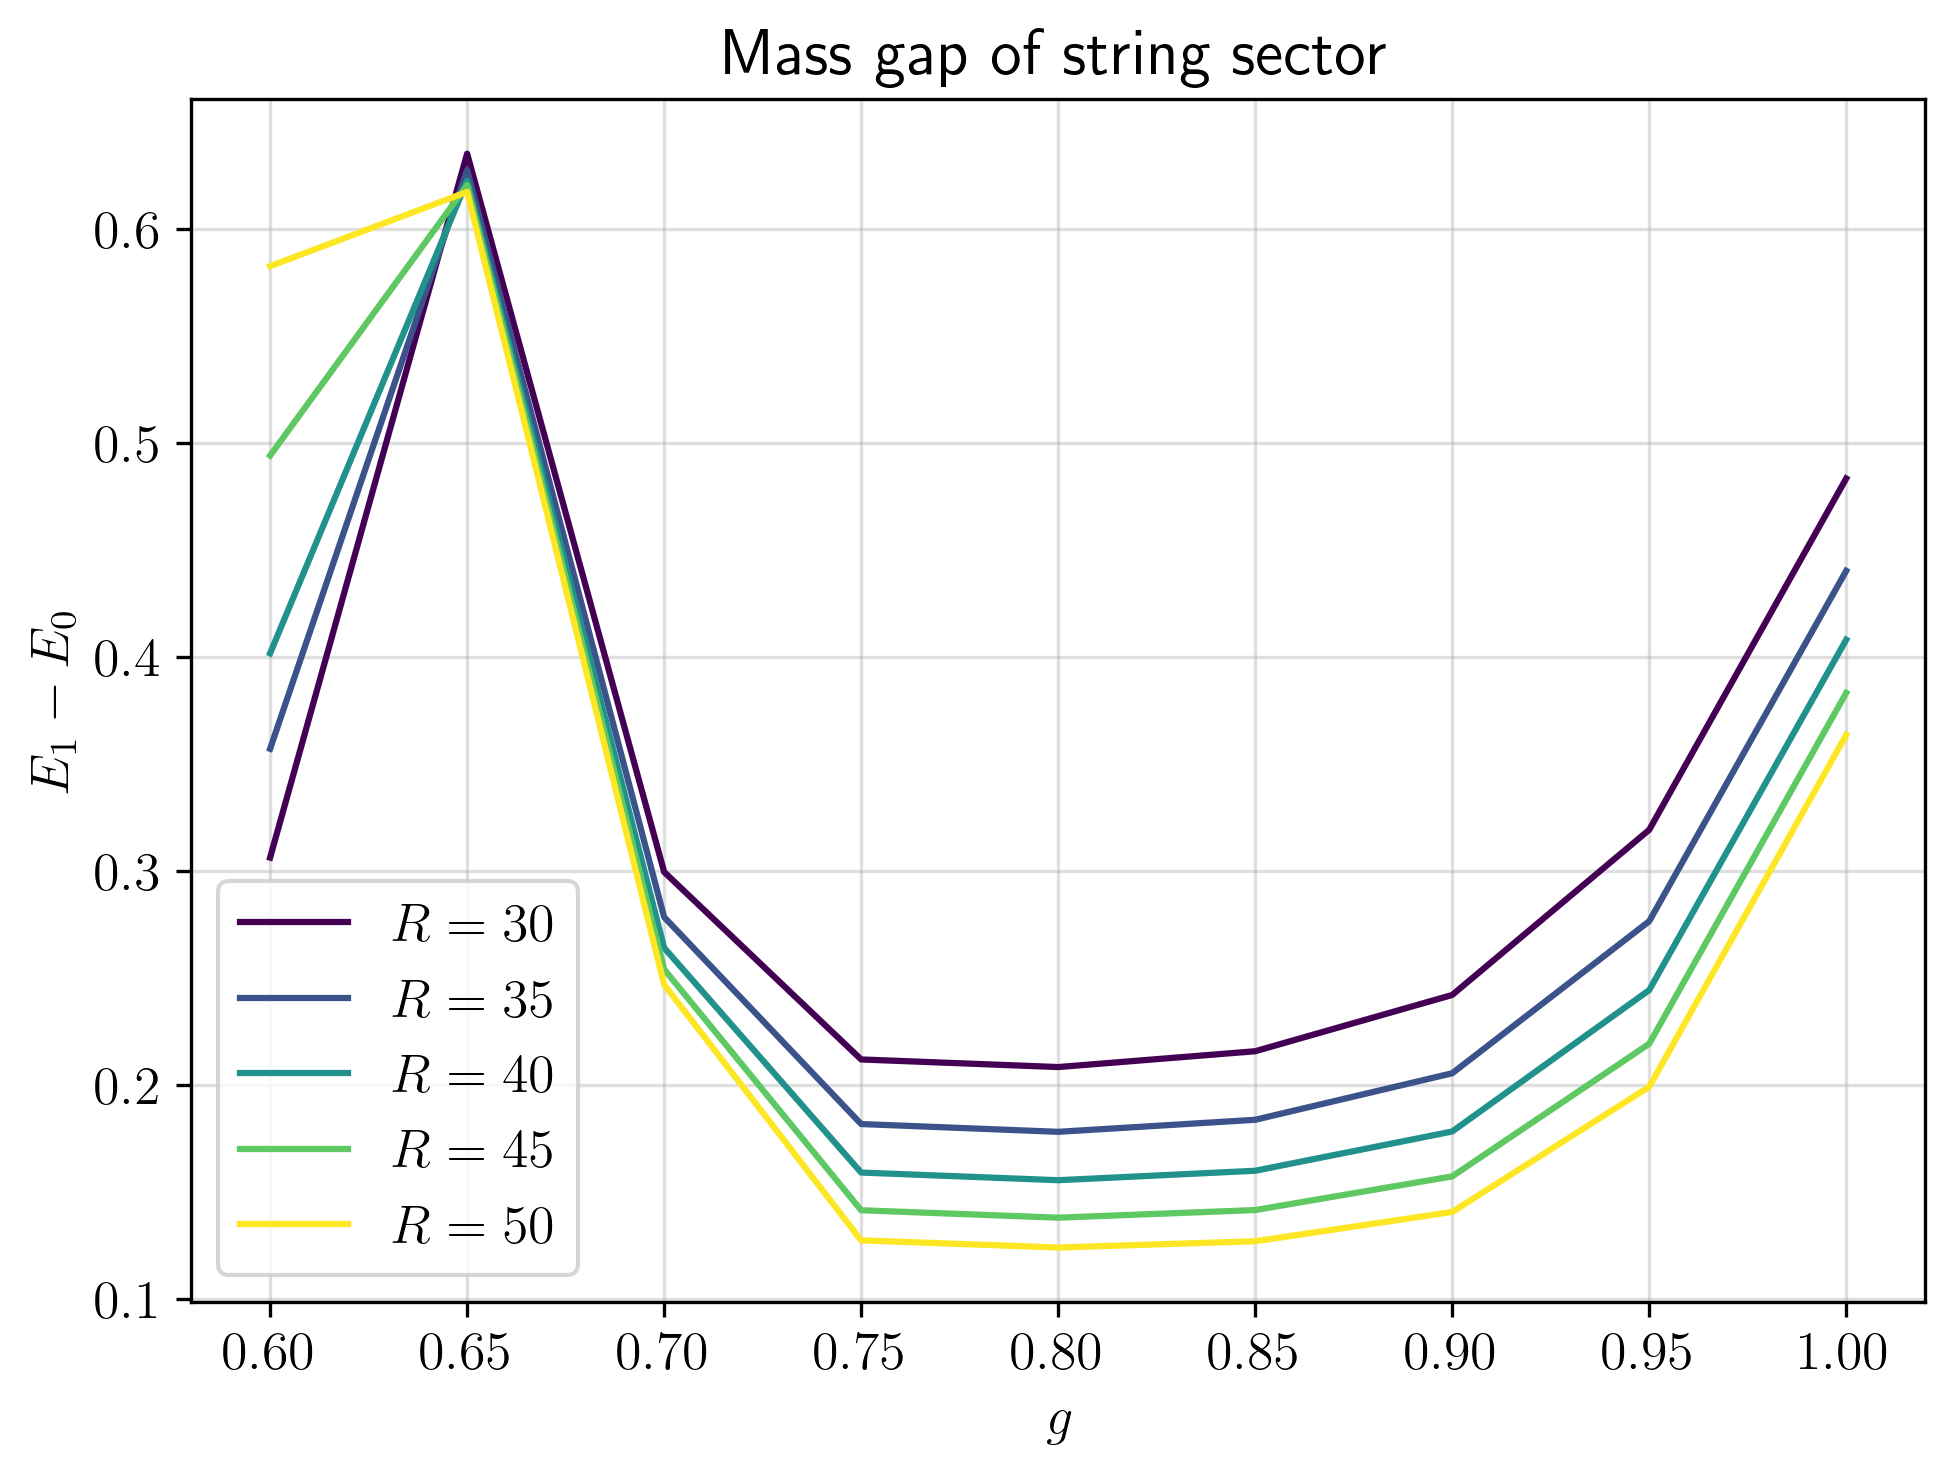

In [30]:
Rs = [30,35,40,45,50]
chi = 192
colors = create_sequential_colors(len(Rs))
for i, R in enumerate(Rs):
    cx = get_cx(L, R)
    cy = get_cy(N, bc, R=R)
    gap = get_mass_gap(cx,cy,chi)
    label= f"$R={R}$"
    plt.plot(gs, gap, color=colors[i], label=label)
plt.grid(True, alpha=0.4)
plt.title("Mass gap of string sector")
plt.xlabel("$g$")
plt.ylabel("$E_1 - E_0$")
plt.legend()